# Data Scrubbing Notebook

## Introduction

The overall goal of this project is to see if I can predict both the annual and monthly sales price per bushel of grain corn (which is what people eat, as opposed to silage corn, which is what livestock eats). The annual predictions are useful for planning for the next year, whereas monthly projections help fine tune plans as the year progresses. I am guessing the monthly data will be easier to model because there is more of it.  

This notebook will be used for scrubbing the data and getting it ready for analysis. To see how good my model is, I will compare it to a baseline that I am defining here as the average price over the last 3 years. For the monthly data, I will also be including a lag of three months to try and model real world information gathering rates.

While most people probably aren't super interested in corn prices, the ideas here are applicable to most market prediction projects, which require domain knowledge and some general ideas of which features drive change. And I chose corn specifically because I REALLY love popcorn, and this is probably the closest I'm going to ever get to being able to work with popcorn data in the foreseeable future.  

I will be taking corn market data from https://quickstats.nass.usda.gov/, which is a US government data repository managed by the US Department of Agriculture with data on a number of crops and livestock. I used the following settings to select my data:
- Sector: "CROPS"
- Commodity: "CORN"
- Data Item: All data items starting in "CORN, GRAIN" except those with other qualifiers (such as "DENT STAGE", "IRRIGATED", or "ORGANIC")
- Geographical Level: "NATIONAL"
- State: "US TOTAL"
- Year: 1950 to 2020
- Period Type: "ANNUAL" and "MONTHLY"
- Period: "MARKETING YEAR", "YEAR", and all the individual months
This data was selected so that I could get broad information about grain corn without getting into nitty gritty details about weather the corn is organic or not. I will check in the next notebook how these data relate to the target feature.

I am assuming that the sales price of corn depends on factors such as how much corn was grown, the quality of the corn, and other market factors, such as market size, inflation, and the overall health of the economy. Therefore, I will be adding a number of features to this corn data. I will be taking climate features, recorded on both an annual and monthly basis, from [ncdc.noaa.gov](https://www.ncdc.noaa.gov/cag/national/time-series), which is another US government repository managed by the National Oceanic and Atmospheric Administration. I will go over which specific features I downloaded when I import the data into this notebook. This weather data should help the model by providing factors that impact corn growth. For market features, I will use the annual US population to help model market size ([multpl.com](https://www.multpl.com/united-states-population/table/by-year)) and the annual inflation rate of the US dollar ([thebalance.com](https://www.thebalance.com/u-s-inflation-rate-history-by-year-and-forecast-3306093)) and the total US GDP and percent change in GDP, recorded both quarterly and annually ([fred.stlouisfed.org](https://fred.stlouisfed.org/series/GDP#0)) to model inflation and market health, respectively.

## Plan of Attack

1. Import Analysis Packages
2. Scrub the corn data
    - Import as a Pandas dataframe
    - Check for proper formatting
    - Check for duplicate values
    - Sort the data into annual and monthly dataframes 
    - Check for missing values
    - Check that dates are formatted correctly
    - other anomalies we could spot
3. Scrub the climate data
    - Import as dataframes
    - Check for proper formatting
    - Check for duplicate or missing values
    - Combine into annual and monthly dataframes
4. Scrub the population and market data 
    - Import as dataframes
    - Check for proper formatting
    - Check for duplicate or missing values
    - Combine the annual data into a dataframe
    - Model monthly data from quarterly GDP features
    - Model monthly population and inflation from annual features
5. Combine individual dataframes into unified annual and monthly dataframes
    - Check for missing values
    - Export for EDA
6. Conclusions

## Import Analysis Packages

Before any project can start, the proper tools must be imported into the workspace. I will be using Python 3 for this project, and python comes with a number of unique packages that will help in cleaning the data, such as `Pandas` and `numpy`. These packages will be imported here.

In [1]:
# import needed tools.
import pandas as pd
import numpy as np
import os
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

## Scrub the corn data

In this section, I will import the corn data as a Pandas dataframe. I will then make sure that it is formatted in a useful way and check for duplicated values. Next, I will split the data into `annual` and `monthly` dataframes, check for missing values, check that dates are formatted correctly, and look for any other possible anomalies.

#### Corn data dictionary:
- `Program`: whether the data was collected by a census or survey
- `Year`
- `Period`: year, month, week, etc.
- `Week Ending`
- `Geo Level`: national, agricultural district, county, etc.
- `State`
- `State ANSI`: unique code for each state
- `Ag District`: local agricultural districts distinct from county boundaries but on a similar scale 
- `Ag District Code`: unique code for each agricultural district
- `County`
- `County ANSI`: unique code for each county
- `Zip Code`
- `Region`: subset of states
- `watershed_code`: unique code for each watershed
- `Watershed`: regions of shared water
- `Commodity`: what commodity the observation is for (all rows are 'CORN' in this data set) 
- `Data Item`: what metric was being measured
- `Domain`: groupings of data items
- `Domain Category`: subgroupings of data items
- `Value`: the numerical value of the metric recorded
- `CV (%)`: the coefficient of variation

All of the data for this project is stored in the Data folder, so I will need to import from there.

In [2]:
# Import the corn data as a Pandas dataframe
corn_df = pd.read_csv('./Data/Corn_Data.csv')

# Confirm the dataframe was imported successfully
display(corn_df)

,Program,Year,Period,Week Ending,Geo Level,State,State ANSI,Ag District,Ag District Code,County,...,Zip Code,Region,watershed_code,Watershed,Commodity,Data Item,Domain,Domain Category,Value,CV (%)
0,CENSUS,2017,YEAR,NaN,NATIONAL,US TOTAL,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,CORN,"CORN, GRAIN - ACRES HARVESTED",AREA HARVESTED,"AREA HARVESTED: (1,000 OR MORE ACRES)","30,769,757",2.9
1,CENSUS,2017,YEAR,NaN,NATIONAL,US TOTAL,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,CORN,"CORN, GRAIN - ACRES HARVESTED",AREA HARVESTED,"AREA HARVESTED: (1,000 TO 1,999 ACRES)","17,996,502",2.4
2,CENSUS,2017,YEAR,NaN,NATIONAL,US TOTAL,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,CORN,"CORN, GRAIN - ACRES HARVESTED",AREA HARVESTED,AREA HARVESTED: (1.0 TO 14.9 ACRES),"250,758",5.7
3,CENSUS,2017,YEAR,NaN,NATIONAL,US TOTAL,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,CORN,"CORN, GRAIN - ACRES HARVESTED",AREA HARVESTED,AREA HARVESTED: (100 TO 249 ACRES),"11,052,437",2.0
4,CENSUS,2017,YEAR,NaN,NATIONAL,US TOTAL,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,CORN,"CORN, GRAIN - ACRES HARVESTED",AREA HARVESTED,AREA HARVESTED: (15.0 TO 24.9 ACRES),"373,394",3.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3308,SURVEY,1950,AUG,NaN,NATIONAL,US TOTAL,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,CORN,"CORN, GRAIN - PRICE RECEIVED, MEASURED IN $ / BU",TOTAL,NOT SPECIFIED,1.44,NaN
3309,SURVEY,1950,SEP,NaN,NATIONAL,US TOTAL,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,CORN,"CORN, GRAIN - PRICE RECEIVED, MEASURED IN $ / BU",TOTAL,NOT SPECIFIED,1.44,NaN
3310,SURVEY,1950,OCT,NaN,NATIONAL,US TOTAL,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,CORN,"CORN, GRAIN - PRICE RECEIVED, MEASURED IN $ / BU",TOTAL,NOT SPECIFIED,1.37,NaN
3311,SURVEY,1950,NOV,NaN,NATIONAL,US TOTAL,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,CORN,"CORN, GRAIN - PRICE RECEIVED, MEASURED IN $ / BU",TOTAL,NOT SPECIFIED,1.37,NaN


The dataframe appears to have been created successfully. There are 3313 rows and 21 columns. Most of these columns, such as `County` and `Zip Code`, contain no information at all because all of the data imported here was collected at the national level. Others, such as `State` and `Commodity` contain only a single value (because all of the data was collected for the `US TOTAL` and for `CORN` respectively). To make this dataframe a little easier to work with, I will keep only the features that are important. These include:
- `Year`
- `Period`
- `Data Item`
- `Domain` 
- `Domain Category`
- `Value`

I will now reset the corn dataframe so that it only contains these columns.

In [3]:
# Set the corn dataframe to only hold the features of interest.
corn_df = corn_df[['Year', 'Period', 'Data Item', 'Domain', 'Domain Category', 'Value']]

# Confirm the dataframe was modified successfully.
display(corn_df)

,Year,Period,Data Item,Domain,Domain Category,Value
0,2017,YEAR,"CORN, GRAIN - ACRES HARVESTED",AREA HARVESTED,"AREA HARVESTED: (1,000 OR MORE ACRES)","30,769,757"
1,2017,YEAR,"CORN, GRAIN - ACRES HARVESTED",AREA HARVESTED,"AREA HARVESTED: (1,000 TO 1,999 ACRES)","17,996,502"
2,2017,YEAR,"CORN, GRAIN - ACRES HARVESTED",AREA HARVESTED,AREA HARVESTED: (1.0 TO 14.9 ACRES),"250,758"
3,2017,YEAR,"CORN, GRAIN - ACRES HARVESTED",AREA HARVESTED,AREA HARVESTED: (100 TO 249 ACRES),"11,052,437"
4,2017,YEAR,"CORN, GRAIN - ACRES HARVESTED",AREA HARVESTED,AREA HARVESTED: (15.0 TO 24.9 ACRES),"373,394"
...,...,...,...,...,...,...
3308,1950,AUG,"CORN, GRAIN - PRICE RECEIVED, MEASURED IN $ / BU",TOTAL,NOT SPECIFIED,1.44
3309,1950,SEP,"CORN, GRAIN - PRICE RECEIVED, MEASURED IN $ / BU",TOTAL,NOT SPECIFIED,1.44
3310,1950,OCT,"CORN, GRAIN - PRICE RECEIVED, MEASURED IN $ / BU",TOTAL,NOT SPECIFIED,1.37
3311,1950,NOV,"CORN, GRAIN - PRICE RECEIVED, MEASURED IN $ / BU",TOTAL,NOT SPECIFIED,1.37


Great! The dataframe still has 3313 rows but now only has 6 columns.  

Now, I want to check that the data is all in the correct format.

In [4]:
# Check the data tyoe stored in each column
corn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3313 entries, 0 to 3312
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Year             3313 non-null   int64 
 1   Period           3313 non-null   object
 2   Data Item        3313 non-null   object
 3   Domain           3313 non-null   object
 4   Domain Category  3313 non-null   object
 5   Value            3313 non-null   object
dtypes: int64(1), object(5)
memory usage: 155.4+ KB


It seems that the `Value` column is storing strings, not numbers. That is likely because the data is recorded with commas. I will have to remove the commas and then convert the column to contain float data.

In [5]:
# Remove all of the commas
corn_df['Value'].replace(',','', regex=True, inplace=True)

# Confirm the commas were removed
display(corn_df)

,Year,Period,Data Item,Domain,Domain Category,Value
0,2017,YEAR,"CORN, GRAIN - ACRES HARVESTED",AREA HARVESTED,"AREA HARVESTED: (1,000 OR MORE ACRES)",30769757
1,2017,YEAR,"CORN, GRAIN - ACRES HARVESTED",AREA HARVESTED,"AREA HARVESTED: (1,000 TO 1,999 ACRES)",17996502
2,2017,YEAR,"CORN, GRAIN - ACRES HARVESTED",AREA HARVESTED,AREA HARVESTED: (1.0 TO 14.9 ACRES),250758
3,2017,YEAR,"CORN, GRAIN - ACRES HARVESTED",AREA HARVESTED,AREA HARVESTED: (100 TO 249 ACRES),11052437
4,2017,YEAR,"CORN, GRAIN - ACRES HARVESTED",AREA HARVESTED,AREA HARVESTED: (15.0 TO 24.9 ACRES),373394
...,...,...,...,...,...,...
3308,1950,AUG,"CORN, GRAIN - PRICE RECEIVED, MEASURED IN $ / BU",TOTAL,NOT SPECIFIED,1.44
3309,1950,SEP,"CORN, GRAIN - PRICE RECEIVED, MEASURED IN $ / BU",TOTAL,NOT SPECIFIED,1.44
3310,1950,OCT,"CORN, GRAIN - PRICE RECEIVED, MEASURED IN $ / BU",TOTAL,NOT SPECIFIED,1.37
3311,1950,NOV,"CORN, GRAIN - PRICE RECEIVED, MEASURED IN $ / BU",TOTAL,NOT SPECIFIED,1.37


The commas were removed successfully.

In [6]:
# Cast the "Value" column as type float
corn_df['Value'] = corn_df['Value'].astype('float')

# Check that the type was converted successfully
corn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3313 entries, 0 to 3312
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Year             3313 non-null   int64  
 1   Period           3313 non-null   object 
 2   Data Item        3313 non-null   object 
 3   Domain           3313 non-null   object 
 4   Domain Category  3313 non-null   object 
 5   Value            3313 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 155.4+ KB


The column type was changed successfully.

I now want to check that only the correct periods appear in the `Period` column. Expected values are "YEAR" and individual month abbreviations.

In [7]:
corn_df['Period'].value_counts()

YEAR              1742
DEC                127
OCT                126
NOV                126
AUG                125
JUL                125
JAN                123
JUN                122
MAR                122
MAY                122
FEB                122
APR                122
SEP                120
MARKETING YEAR      89
Name: Period, dtype: int64

Interesting. Some years seem to have been recorded as marketing years. The `Marketing Year` for corn begins on January 1 ([Ref](https://en.wikipedia.org/wiki/Marketing_year)), so `Marketing Year` can be converted to year. However, I want to make sure the value of interest (sales price per bushel) is recorded consistently first.

In [8]:
# Filter for desired 'Data Item'
filter_for_data_item = corn_df['Data Item'] == 'CORN, GRAIN - PRICE RECEIVED, MEASURED IN $ / BU'

# Filters for desired 'Period' values
filter_for_period_year = corn_df['Period'] == 'YEAR'
filter_for_period_market_year = corn_df['Period'] == 'MARKETING YEAR'

# Change the options on a dataframe to show all of the rows.
# I will need to change this back for later work.
pd.set_option("display.max_rows", None)

# Show the filtered dataframe
display(corn_df[filter_for_period_year & filter_for_data_item | filter_for_period_market_year & filter_for_data_item])

,Year,Period,Data Item,Domain,Domain Category,Value
1433,2020,MARKETING YEAR,"CORN, GRAIN - PRICE RECEIVED, MEASURED IN $ / BU",TOTAL,NOT SPECIFIED,4.53
1436,2020,YEAR,"CORN, GRAIN - PRICE RECEIVED, MEASURED IN $ / BU",TOTAL,NOT SPECIFIED,3.50
1488,2019,MARKETING YEAR,"CORN, GRAIN - PRICE RECEIVED, MEASURED IN $ / BU",TOTAL,NOT SPECIFIED,3.56
1491,2019,YEAR,"CORN, GRAIN - PRICE RECEIVED, MEASURED IN $ / BU",TOTAL,NOT SPECIFIED,3.75
1543,2018,MARKETING YEAR,"CORN, GRAIN - PRICE RECEIVED, MEASURED IN $ / BU",TOTAL,NOT SPECIFIED,3.61
1546,2018,YEAR,"CORN, GRAIN - PRICE RECEIVED, MEASURED IN $ / BU",TOTAL,NOT SPECIFIED,3.47
1598,2017,MARKETING YEAR,"CORN, GRAIN - PRICE RECEIVED, MEASURED IN $ / BU",TOTAL,NOT SPECIFIED,3.36
1601,2017,YEAR,"CORN, GRAIN - PRICE RECEIVED, MEASURED IN $ / BU",TOTAL,NOT SPECIFIED,3.36
1653,2016,MARKETING YEAR,"CORN, GRAIN - PRICE RECEIVED, MEASURED IN $ / BU",TOTAL,NOT SPECIFIED,3.36
1656,2016,YEAR,"CORN, GRAIN - PRICE RECEIVED, MEASURED IN $ / BU",TOTAL,NOT SPECIFIED,3.48


It seems that the `CORN, GRAIN - PRICE RECEIVED, MEASURED IN $ / BU` was only recorded by `YEAR` starting in 1996. However, this feature was recorded by `MARKET YEAR` every year in the dataframe. At this point, I would likely go to the data engineers and ask whats going on. But here, I'll just drop the values recorded by `YEAR`.

In [9]:
# Filter for rows to drop
rows_to_drop = corn_df[filter_for_period_year & filter_for_data_item].index

# Drop the desired rows
corn_df.drop(index=rows_to_drop, inplace=True)

# Confirm the rows no longer exist in the dataframe.
corn_df[filter_for_period_year & filter_for_data_item]

<ipython-input-9-4465b6825cd0>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  corn_df[filter_for_period_year & filter_for_data_item]


,Year,Period,Data Item,Domain,Domain Category,Value


The desired data filter seems to have been implemented correctly. 

I will now change the Pandas options back so that entire dataframes are no longer displayed.

In [10]:
pd.reset_option('display')

I will now change all periods labeled `MARKETING YEAR` to `YEAR`.

In [11]:
# select all rows where the period equals marketing year
marketing_filter = corn_df['Period'] == 'MARKETING YEAR'

# convert the period in each of these rows to "YEAR"
corn_df.loc[marketing_filter, 'Period'] = 'YEAR'

# confirm that the transformation worked successfully
display(corn_df["Period"].value_counts())

YEAR    1806
DEC      127
OCT      126
NOV      126
AUG      125
JUL      125
JAN      123
JUN      122
MAR      122
MAY      122
FEB      122
APR      122
SEP      120
Name: Period, dtype: int64

The `Period` column now only has the expected values.

I now want to check for any duplicated data.

In [12]:
# This function will check each row to see if it is duplicated and return a series of True
# or False for each. The sumfunction will then add up all of the values (1 for True, 0 for False). 
corn_df.duplicated(keep=False).sum()

0

There appear to be no duplicated values. At this point, I could check for missing values as well. However, the current corn dataframe isn't formatted the way I would like. I would rather have two dataframes, one for the annual data and one for the monthly data. I would like the index of these dataframes to be the date and the columns to be associated with the different data items. However, I can see from the corn dataframe that some of the `Data Item` values are not unique by themselves. Some of the same data items are listed for different `Domain Category` values in a given year. For example, the first five data items are all "CORN, GRAIN - ACRES HARVESTED" for the year 2017, but the domain categories list different area categories, such as "AREA HARVESTED: (1,000 OR MORE ACRES)" and "AREA HARVESTED: (1.0 TO 14.9 ACRES)". This may also be true for the `Domain` column. I want to check to see if I can get all unique values for just the `Year`, `Period`, `Data Item`, and `Domain Category` features. In other words, I want to see if I can drop the `Domain` column.

In [13]:
# Check to see if the following groups of features can give all unique values.
corn_df[['Year', 'Period', 'Data Item', 'Domain Category']].duplicated(keep=False).sum()

20

It looks like the `Domain` column is needed to distinguish 20 rows. Let's see what those rows are.

In [14]:
# Filter the corn dataframe for rows with duplicate combinations of the four features listed.
corn_df[corn_df[['Year', 'Period', 'Data Item', 'Domain Category']].duplicated(keep=False)].sort_values(['Year', 'Data Item'])

,Year,Period,Data Item,Domain,Domain Category,Value
1406,1997,YEAR,"CORN, GRAIN - ACRES HARVESTED",TOTAL,NOT SPECIFIED,7.108845e+07
2495,1997,YEAR,"CORN, GRAIN - ACRES HARVESTED",TOTAL,NOT SPECIFIED,7.267100e+07
1432,1997,YEAR,"CORN, GRAIN - PRODUCTION, MEASURED IN BU",TOTAL,NOT SPECIFIED,8.732478e+09
2498,1997,YEAR,"CORN, GRAIN - PRODUCTION, MEASURED IN BU",TOTAL,NOT SPECIFIED,9.206832e+09
1364,2002,YEAR,"CORN, GRAIN - ACRES HARVESTED",TOTAL,NOT SPECIFIED,6.823052e+07
2401,2002,YEAR,"CORN, GRAIN - ACRES HARVESTED",TOTAL,NOT SPECIFIED,6.933000e+07
1393,2002,YEAR,"CORN, GRAIN - PRODUCTION, MEASURED IN BU",TOTAL,NOT SPECIFIED,8.613062e+09
2404,2002,YEAR,"CORN, GRAIN - PRODUCTION, MEASURED IN BU",TOTAL,NOT SPECIFIED,8.966787e+09
1323,2007,YEAR,"CORN, GRAIN - ACRES HARVESTED",TOTAL,NOT SPECIFIED,8.624854e+07
2148,2007,YEAR,"CORN, GRAIN - ACRES HARVESTED",TOTAL,NOT SPECIFIED,8.652000e+07


Interesting. These rows actually don't need to be distinguished by the `Domain` category. There are just several rows that have duplicate data entries but with different `Value` values. Hence, they weren't caught by the `duplicated` function by themselves. Fortunately, it doesn't look like any of the duplicate entries differ substantially one from another. So, I can probably set the first entries `Value` as an average of the two values and then drop the second row from the dataframe. That way information is retained from each row and there won't be any repeated values.

In [15]:
# Create a list that conatins the indexes of the duplicated rows.
# In this list, each set of duplicate rows is grouped together. 
filter_list = corn_df[corn_df[['Year', 'Period', 'Data Item', 'Domain Category']].duplicated(keep=False)].sort_values(['Year', 'Data Item']).index

# I will then use a for loop to iterate through the indexes of interest in the corn dataframe. 
for i in range(len(filter_list)):
    
    # If the row is the first of the duplicated rows, I want the value of the 
    # 'Value' column set as an average of the two duplicate values. 
    # For each first duplicate, the index will be even (or zero), and for the 
    # second duplicate the index will be odd. So, I will write a function that
    # checks if the index is even or odd and then proceeds accordingly.
    if i % 2:
        
        # If the index is odd, drop the row from the corn dataframe 
        corn_df.drop(index=filter_list[i], inplace=True)
        
        # Check that the row was dropped
        if filter_list[i] not in corn_df.index:
            print(f'Index {filter_list[i]} deleted successfully.')
        
    else:
        
        # If the index is even (or zero), average the value with the next value indexed by the filter list
        
        # Store the original values first for comparison 
        original1 = corn_df.loc[filter_list[i]]['Value']
        original2 = corn_df.loc[filter_list[i+1]]['Value']
        
        # Change the value
        corn_df['Value'][filter_list[i]] = (original1 + original2) / 2
        
        # Check to see if the value changed successfully.
        if corn_df['Value'][filter_list[i]] != original1:
            print(f'Index {filter_list[i]} updated successfully.')

Index 1406 updated successfully.
Index 2495 deleted successfully.
Index 1432 updated successfully.
Index 2498 deleted successfully.
Index 1364 updated successfully.
Index 2401 deleted successfully.
Index 1393 updated successfully.
Index 2404 deleted successfully.
Index 1323 updated successfully.
Index 2148 deleted successfully.
Index 1351 updated successfully.
Index 2151 deleted successfully.
Index 683 updated successfully.
Index 1875 deleted successfully.
Index 1302 updated successfully.
Index 1878 deleted successfully.
Index 84 updated successfully.
Index 1600 deleted successfully.
Index 578 updated successfully.
Index 1603 deleted successfully.


<ipython-input-15-7d3acd3c13aa>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corn_df['Value'][filter_list[i]] = (original1 + original2) / 2


I will now check for duplicates again, and this time the results should be empty.

In [16]:
# Filter the corn dataframe for rows with duplicate combinations of the four features listed.
corn_df[corn_df[['Year', 'Period', 'Data Item', 'Domain Category']].duplicated(keep=False)].sort_values(['Year', 'Data Item'])

,Year,Period,Data Item,Domain,Domain Category,Value


Excellent! The duplicates have been corrected for.  

I now want to create a new column that is a combination of the `Data Item` and `Domain Category` into a new column called `measurement`. However, the `Domain Category` can have a value of "NOT SPECIFIED", which is not useful information to retain. So, if "NOT SPECIFIED" appears, I won't add the domain category to the new column, just the data item information. I will then drop the `Data Item`, `Domain`, and `Domain Category` columns.

In [17]:
# Add the "Data Item" values to the new column
corn_df['measurement'] = corn_df['Data Item']

# Iterate through the rows of the corn dataframe
for i, row in corn_df.iterrows():
    
    # If the "Domain Category" does not equal "NOT SPECIFIED", add the value to the new column
    if corn_df['Domain Category'][i] != "NOT SPECIFIED":
        corn_df['measurement'][i] += ' -> ' + corn_df['Domain Category'][i]

# Confirm the new column was created successfully
display(corn_df)

<ipython-input-17-909d6439771b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corn_df['measurement'][i] += ' -> ' + corn_df['Domain Category'][i]


,Year,Period,Data Item,Domain,Domain Category,Value,measurement
0,2017,YEAR,"CORN, GRAIN - ACRES HARVESTED",AREA HARVESTED,"AREA HARVESTED: (1,000 OR MORE ACRES)",30769757.00,"CORN, GRAIN - ACRES HARVESTED -> AREA HARVESTE..."
1,2017,YEAR,"CORN, GRAIN - ACRES HARVESTED",AREA HARVESTED,"AREA HARVESTED: (1,000 TO 1,999 ACRES)",17996502.00,"CORN, GRAIN - ACRES HARVESTED -> AREA HARVESTE..."
2,2017,YEAR,"CORN, GRAIN - ACRES HARVESTED",AREA HARVESTED,AREA HARVESTED: (1.0 TO 14.9 ACRES),250758.00,"CORN, GRAIN - ACRES HARVESTED -> AREA HARVESTE..."
3,2017,YEAR,"CORN, GRAIN - ACRES HARVESTED",AREA HARVESTED,AREA HARVESTED: (100 TO 249 ACRES),11052437.00,"CORN, GRAIN - ACRES HARVESTED -> AREA HARVESTE..."
4,2017,YEAR,"CORN, GRAIN - ACRES HARVESTED",AREA HARVESTED,AREA HARVESTED: (15.0 TO 24.9 ACRES),373394.00,"CORN, GRAIN - ACRES HARVESTED -> AREA HARVESTE..."
...,...,...,...,...,...,...,...
3308,1950,AUG,"CORN, GRAIN - PRICE RECEIVED, MEASURED IN $ / BU",TOTAL,NOT SPECIFIED,1.44,"CORN, GRAIN - PRICE RECEIVED, MEASURED IN $ / BU"
3309,1950,SEP,"CORN, GRAIN - PRICE RECEIVED, MEASURED IN $ / BU",TOTAL,NOT SPECIFIED,1.44,"CORN, GRAIN - PRICE RECEIVED, MEASURED IN $ / BU"
3310,1950,OCT,"CORN, GRAIN - PRICE RECEIVED, MEASURED IN $ / BU",TOTAL,NOT SPECIFIED,1.37,"CORN, GRAIN - PRICE RECEIVED, MEASURED IN $ / BU"
3311,1950,NOV,"CORN, GRAIN - PRICE RECEIVED, MEASURED IN $ / BU",TOTAL,NOT SPECIFIED,1.37,"CORN, GRAIN - PRICE RECEIVED, MEASURED IN $ / BU"


The new column was created successfully. And, when the `Domain Category` equaled "NOT SPECIFIED", the domain category information was not added to the new column.

In [18]:
# Drop the columns 'Data Item', 'Domain', and 'Domain Category'
corn_df.drop(columns=['Data Item', 'Domain', 'Domain Category'], inplace=True)

# Confirm the columns were dropped successfully
display(corn_df)

,Year,Period,Value,measurement
0,2017,YEAR,30769757.00,"CORN, GRAIN - ACRES HARVESTED -> AREA HARVESTE..."
1,2017,YEAR,17996502.00,"CORN, GRAIN - ACRES HARVESTED -> AREA HARVESTE..."
2,2017,YEAR,250758.00,"CORN, GRAIN - ACRES HARVESTED -> AREA HARVESTE..."
3,2017,YEAR,11052437.00,"CORN, GRAIN - ACRES HARVESTED -> AREA HARVESTE..."
4,2017,YEAR,373394.00,"CORN, GRAIN - ACRES HARVESTED -> AREA HARVESTE..."
...,...,...,...,...
3308,1950,AUG,1.44,"CORN, GRAIN - PRICE RECEIVED, MEASURED IN $ / BU"
3309,1950,SEP,1.44,"CORN, GRAIN - PRICE RECEIVED, MEASURED IN $ / BU"
3310,1950,OCT,1.37,"CORN, GRAIN - PRICE RECEIVED, MEASURED IN $ / BU"
3311,1950,NOV,1.37,"CORN, GRAIN - PRICE RECEIVED, MEASURED IN $ / BU"


The columns were dropped successfully.

All of the `measurement` values have the phrase "CORN, GRAIN - " at the beginning of them. That makes the data kind of hard to read. I am going to remove that phrase.

In [19]:
# split the "Data Item" column into two columns, seperating them at the proper string
corn_df[['Corn, Grain','measurement']] = corn_df['measurement'].str.split(' - ', expand=True)

# drop the "Corn, Grain" column
corn_df.drop(columns='Corn, Grain', inplace=True)

# confirm that the data was modified successfully
display(corn_df)

,Year,Period,Value,measurement
0,2017,YEAR,30769757.00,"ACRES HARVESTED -> AREA HARVESTED: (1,000 OR M..."
1,2017,YEAR,17996502.00,"ACRES HARVESTED -> AREA HARVESTED: (1,000 TO 1..."
2,2017,YEAR,250758.00,ACRES HARVESTED -> AREA HARVESTED: (1.0 TO 14....
3,2017,YEAR,11052437.00,ACRES HARVESTED -> AREA HARVESTED: (100 TO 249...
4,2017,YEAR,373394.00,ACRES HARVESTED -> AREA HARVESTED: (15.0 TO 24...
...,...,...,...,...
3308,1950,AUG,1.44,"PRICE RECEIVED, MEASURED IN $ / BU"
3309,1950,SEP,1.44,"PRICE RECEIVED, MEASURED IN $ / BU"
3310,1950,OCT,1.37,"PRICE RECEIVED, MEASURED IN $ / BU"
3311,1950,NOV,1.37,"PRICE RECEIVED, MEASURED IN $ / BU"


I now want to split the data into annual and monthly data

In [20]:
# All rows where the Period equals "YEAR" belong to the annual data
corn_df_year = corn_df[corn_df['Period'] == "YEAR"]

# All other data is monthly data
corn_df_month = corn_df[corn_df['Period'] != "YEAR"]

# Reset the indeces of the new dataframes for convenience
corn_df_year.reset_index(drop=True, inplace=True)
corn_df_month.reset_index(drop=True, inplace=True)

# Confirm the dataframes were created successfully
display(corn_df_year, corn_df_month)

,Year,Period,Value,measurement
0,2017,YEAR,3.076976e+07,"ACRES HARVESTED -> AREA HARVESTED: (1,000 OR M..."
1,2017,YEAR,1.799650e+07,"ACRES HARVESTED -> AREA HARVESTED: (1,000 TO 1..."
2,2017,YEAR,2.507580e+05,ACRES HARVESTED -> AREA HARVESTED: (1.0 TO 14....
3,2017,YEAR,1.105244e+07,ACRES HARVESTED -> AREA HARVESTED: (100 TO 249...
4,2017,YEAR,3.733940e+05,ACRES HARVESTED -> AREA HARVESTED: (15.0 TO 24...
...,...,...,...,...
1791,1950,YEAR,1.520000e+00,"PRICE RECEIVED, MEASURED IN $ / BU"
1792,1950,YEAR,7.239800e+07,ACRES HARVESTED
1793,1950,YEAR,4.222366e+09,"PRODUCTION, MEASURED IN $"
1794,1950,YEAR,2.764071e+09,"PRODUCTION, MEASURED IN BU"


,Year,Period,Value,measurement
0,2020,JAN,3.79,"PRICE RECEIVED, MEASURED IN $ / BU"
1,2020,JAN,29.00,"PRICE RECEIVED, MEASURED IN PCT OF PARITY"
2,2020,JAN,12.90,"PRICE RECEIVED, PARITY, MEASURED IN $ / BU"
3,2020,JAN,12.60,"SALES, MEASURED IN PCT OF MKTG YEAR"
4,2020,FEB,3.78,"PRICE RECEIVED, MEASURED IN $ / BU"
...,...,...,...,...
1477,1950,AUG,1.44,"PRICE RECEIVED, MEASURED IN $ / BU"
1478,1950,SEP,1.44,"PRICE RECEIVED, MEASURED IN $ / BU"
1479,1950,OCT,1.37,"PRICE RECEIVED, MEASURED IN $ / BU"
1480,1950,NOV,1.37,"PRICE RECEIVED, MEASURED IN $ / BU"


The new dataframes appear to have been created successfully. However, they are hard to interpret in the current format. To find a specific measurement, you would have to find that measurement for a given year by scrolling through a huge list of values. I will make another new dataframe for the annual and monthly data, but in the new dataframe, the features will correspond to the unique `measurement` values in the previous dataframes.

#### Organized Annual DataFrame

I will start with the annual data by counting the number of unique measurement values and how many of each measurement were made.

In [21]:
corn_df_year['measurement'].value_counts()

PRICE RECEIVED, MEASURED IN $ / BU                                                                                                                    71
PRODUCTION, MEASURED IN BU                                                                                                                            71
PRODUCTION, MEASURED IN $                                                                                                                             71
YIELD, MEASURED IN BU / ACRE                                                                                                                          71
ACRES HARVESTED                                                                                                                                       71
                                                                                                                                                      ..
OPERATIONS WITH AREA HARVESTED -> OPERATORS: (1 OPERATORS) AND AREA HARVESTED: (25

There are 791 unique items. For good model performance, ideally you would want no missing data. However, if 5% or 10% is missing, some meaningful results might still be available. I will now check to see how many of the individual items are recorded for at least 90% of the years. 

In [22]:
# Count unique values that are recorded for at least 90% of the years 
(corn_df_year['measurement'].value_counts() >= 71 * .90).sum()

5

Wow! There are only 5 features recorded for 90% of the years or more. I will therefore filter down to only these features.

In [23]:
# Create a series of all measurement's and a Boolean indicating if the value was not recorded for at least 90% of the years
measurement_value_count_series = corn_df_year['measurement'].value_counts() <= 71 * .90

# Create a list for storing Values that were not recorded for at least 90% of the years
drop_values = list()

# Iterate over the value count series
for value, boolean in measurement_value_count_series.iteritems():
    
    # If the boolean is "True", add the value to the drop list
    if boolean:
        drop_values.append(value)

# drop the various rows from the
for row in drop_values:
    measurement_filter = corn_df_year[corn_df_year['measurement'] == row]
    corn_df_year.drop(measurement_filter.index, inplace=True)

# Confirm only desired measurements remain
print(corn_df_year['measurement'].value_counts())

C:\Users\Daniel\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


PRICE RECEIVED, MEASURED IN $ / BU    71
PRODUCTION, MEASURED IN $             71
YIELD, MEASURED IN BU / ACRE          71
PRODUCTION, MEASURED IN BU            71
ACRES HARVESTED                       71
Name: measurement, dtype: int64


I am now ready to construct the annual data frame with `measurement` values as column names.

In [24]:
# Create a list of columns for the new dataframe
cols = np.insert(corn_df_year['measurement'].unique(), 0, 'Year')

# Create the new, organized dataframe
corn_organized_year = pd.DataFrame(columns=cols)

# I will now populate this table with the proper years and 'nan' for all other entries to make sure the data frame has the proper shape.
# I want the table to conatin data for years 1950 through 2020
for year in range(1950,2021):
    # For the given year, set the year and fill all other values in the row with 'nan'
    corn_organized_year.loc[len(corn_organized_year.index)] = [year, np.nan, np.nan, np.nan, np.nan, np.nan]

# Set the year to integer format and then set year as the index
corn_organized_year['Year'] = corn_organized_year['Year'].astype('int')
corn_organized_year.set_index('Year', drop=True, inplace=True)

# Confirm the data frame was constructed successfully
display(corn_organized_year)

,ACRES HARVESTED,"PRODUCTION, MEASURED IN BU","PRICE RECEIVED, MEASURED IN $ / BU","PRODUCTION, MEASURED IN $","YIELD, MEASURED IN BU / ACRE"
Year,,,,,
1950,NaN,NaN,NaN,NaN,NaN
1951,NaN,NaN,NaN,NaN,NaN
1952,NaN,NaN,NaN,NaN,NaN
1953,NaN,NaN,NaN,NaN,NaN
1954,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2016,NaN,NaN,NaN,NaN,NaN
2017,NaN,NaN,NaN,NaN,NaN
2018,NaN,NaN,NaN,NaN,NaN


The dataframe appears to have been created successfully. I will now populate the table with the proper data. Each row in the `corn_df_year` dataframe contains a unique data item. I will thus scan through each line of the `corn_df_year` data frame, check which data item is there and for which year and put it in the appropriate cell in the `corn_organized_year` dataframe.

In [25]:
# iterate through each row of the corn_df_year data frame.
for i in corn_df_year.index:
        
        # Determine which year the measurement was collected for.
        year = corn_df_year['Year'][i]
        
        # Find the row in the corn_organized_year data frame where the measurement should go.
        ind = corn_organized_year[corn_organized_year.index == year].index[0]
        
        # Add the data to the corn_organized_year data frame in the column with the same measurement and year 
        corn_organized_year[corn_df_year['measurement'][i]][ind] = corn_df_year['Value'][i]
        
# confirm the data frame was populated correctly
display(corn_organized_year)

,ACRES HARVESTED,"PRODUCTION, MEASURED IN BU","PRICE RECEIVED, MEASURED IN $ / BU","PRODUCTION, MEASURED IN $","YIELD, MEASURED IN BU / ACRE"
Year,,,,,
1950,72398000.0,2.764071e+09,1.52,4.222366e+09,38.2
1951,71191000.0,2.628937e+09,1.66,4.364659e+09,36.9
1952,71353000.0,2.980793e+09,1.52,4.557031e+09,41.8
1953,70738000.0,2.881801e+09,1.48,4.291366e+09,40.7
1954,68668000.0,2.707913e+09,1.43,3.872433e+09,39.4
...,...,...,...,...,...
2016,86748000.0,1.514804e+10,3.36,5.130430e+10,174.6
2017,83735781.0,1.469141e+10,3.36,4.956785e+10,176.6
2018,81276000.0,1.434037e+10,3.61,5.210240e+10,176.4


Excellent! The annual corn data seems organized and clean. I will now do one last check for missing values before exporting the dataframe for later use.

In [26]:
# Check for missing values
corn_organized_year.isna().sum()

ACRES HARVESTED                       0
PRODUCTION, MEASURED IN BU            0
PRICE RECEIVED, MEASURED IN $ / BU    0
PRODUCTION, MEASURED IN $             0
YIELD, MEASURED IN BU / ACRE          0
dtype: int64

There appear to be no missing values in this dataframe.

I will now export this dataframe to the `DataFrames` folder. I like to export all important dataframes for future use.

In [27]:
corn_organized_year.to_csv('./DataFrames/corn_organized_year.csv')

#### Organized Monthly DataFrame

I will now start on the monthly data by counting the number of unique measurement values and how many of each measurement were made.

In [28]:
# Total number of months in the years 1950 to 2021
print(12*71)

# Unique value counts
corn_df_month['measurement'].value_counts()

852


PRICE RECEIVED, MEASURED IN $ / BU                      852
SALES, MEASURED IN PCT OF MKTG YEAR                     220
PRICE RECEIVED, PARITY, MEASURED IN $ / BU              196
PRICE RECEIVED, MEASURED IN PCT OF PARITY               196
PRICE RECEIVED, ADJUSTED BASE, MEASURED IN $ / BU        17
RELATIVE WEIGHT, MEASURED IN PCT OF COMMODITY TOTALS      1
Name: measurement, dtype: int64

There are 852 months in the years from 1950 to 2021, and only one feature has been recorded this many times: `PRICE RECEIVED, MEASURED IN $ / BU`. All other features were measured at most for only about a quarter of those months. So, the `PRICE RECEIVED, MEASURED IN $ / BU`, the target value, is the only value worth keeping from these data. I will now filter the dataframe accordingly.

In [29]:
# Keep only the measurement of interest
corn_df_month = corn_df_month[corn_df_month['measurement'] == 'PRICE RECEIVED, MEASURED IN $ / BU']

# Confirm that there is only one unique value left
corn_df_month['measurement'].value_counts()

PRICE RECEIVED, MEASURED IN $ / BU    852
Name: measurement, dtype: int64

I am now ready to construct the monthly dataframe with `Year`, `Month` (from `Period`), and `PRICE RECEIVED, MEASURED IN $ / BU` populated with the `Value` values. I will then set the year-month combination as the index.

In [30]:
# Create the new dataframe
corn_organized_month = pd.DataFrame(columns=['Year', 'Month', 'month', 'PRICE RECEIVED, MEASURED IN $ / BU'])

# Create a list of Month by name and order
months = [('JAN', 1), ('FEB', 2), ('MAR', 3), ('APR', 4), ('MAY', 5), ('JUN', 6), ('JUL', 7), ('AUG', 8), ('SEP', 9), ('OCT', 10), ('NOV', 11), ('DEC', 12)]

# iterate through each year from 1950 to 2020
for year in range(1950,2021):
    
    # iterate through the named month list
    for month in months:
        
        # Find the current length of the table and add a new row.
        # Because the data frame is zero indexed, the index of the row to add will 
        # always be equal to the current length of the data frame.
        # Add the year, the name and order number of the months, and 'nan' for the price recieved column.
        corn_organized_month.loc[len(corn_organized_month.index)] = [int(year), month[0], month[1], np.nan] 

# check that the data frame was created successfully.
display(corn_organized_month)

,Year,Month,month,"PRICE RECEIVED, MEASURED IN $ / BU"
0,1950,JAN,1,NaN
1,1950,FEB,2,NaN
2,1950,MAR,3,NaN
3,1950,APR,4,NaN
4,1950,MAY,5,NaN
...,...,...,...,...
847,2020,AUG,8,NaN
848,2020,SEP,9,NaN
849,2020,OCT,10,NaN
850,2020,NOV,11,NaN


The dataframe has been created successfully. I will now fill in the price received data.

In [31]:
# iterate through each row of the corn_df_month data frame
for i in corn_df_month.index:
        
    # determine which year and month the data were collected for
    year = corn_df_month['Year'][i]
    month = corn_df_month['Period'][i]
        
    # Filter out all of the data that does not correspond to the correct year and month.
    # This will leave only a single row.
    year_filter = (corn_organized_month["Year"] == year)
    month_filter = (corn_organized_month["Month"] == month)
        
    # Apply the filters and determine the index of the remaining row.
    ind = corn_organized_month[year_filter & month_filter].index[0]
        
    # Put the data in the appropriate row and column.
    corn_organized_month['PRICE RECEIVED, MEASURED IN $ / BU'][ind] = corn_df_month['Value'][i]

# confirm the data frame was populated successfully
display(corn_organized_month)

,Year,Month,month,"PRICE RECEIVED, MEASURED IN $ / BU"
0,1950,JAN,1,1.15
1,1950,FEB,2,1.16
2,1950,MAR,3,1.19
3,1950,APR,4,1.26
4,1950,MAY,5,1.34
...,...,...,...,...
847,2020,AUG,8,3.12
848,2020,SEP,9,3.41
849,2020,OCT,10,3.61
850,2020,NOV,11,3.79


The dataframe is looking good. I will now set the index equal to the year-month combo.

In [32]:
# Add a day column so I can make a date column from the year, month, and day
corn_organized_month['day'] = 1

# Create the date column from the year, month, and day
corn_organized_month['date'] = pd.to_datetime(corn_organized_month[['Year', 'month', 'day']])

# Create the DatetimeIndex
didx = pd.DatetimeIndex(data=corn_organized_month['date'], freq ='MS')

# Set the datetime as the index
corn_organized_month.set_index(didx, inplace=True)

# Drop all other date related columns from the data frame
corn_organized_month.drop(columns=['Year', 'Month', 'month', 'day', 'date'], inplace=True)

# Confirm the dataframe was updated successfully
display(corn_organized_month)

,"PRICE RECEIVED, MEASURED IN $ / BU"
date,
1950-01-01,1.15
1950-02-01,1.16
1950-03-01,1.19
1950-04-01,1.26
1950-05-01,1.34
...,...
2020-08-01,3.12
2020-09-01,3.41
2020-10-01,3.61


Looks good. I will now do one last check for missing values before exporting the dataframe for later use.

In [33]:
# Check for missing values
corn_organized_month.isna().sum()

PRICE RECEIVED, MEASURED IN $ / BU    0
dtype: int64

There appear to be no missing values in this dataframe.

I will now export this dataframe to the `DataFrames` folder. I like to export all important dataframes for future use.

In [34]:
corn_organized_month.to_csv('./DataFrames/corn_organized_month.csv')

## Scrub the climate data

In this section I will import the climate data as Panda dataframes. I will then check that the dataframes are properly formatted, look for any duplicated or missing data, and combine all of the data into annual and monthly dataframes.

### Climate Data Dictionary
- `Cooling Degree Days`: a measure of how many degrees and how many days the temperature is above room temperature
- `Heating Degree Days`: a measure of how many degrees and how many days the temperature is below room temperature
- `Precipitation`: total rainfall in inches, averaged across all 50 states
- `Palmer Drought Severity Index (PDSI)`: a measure of relative dryness
- `Average Temperature`: average temperature across all 50 states 
- `Maximum Temperature`: average maximum temperature across all 50 states
- `Minimum Temperature`: average minimum temperature across all 50 states

All of these data were collected both annually and monthly.

The csv files containing these features as a function of year are stored in the `Climate Data` folder.

### Annual climate data

I will now import the annual climate data as individual dataframes. I will create a list to hold all of the data frames, which will make it easier to iterate through the individual dataframes as I clean them and later combine them into a single annual data frame.

In [35]:
# First, I will create the list for storing the individual climate data frames.
climate_list_annual = []

# I will then read through the csv files in the "Data/Annual_Climate_Data" folder 
# and add them as data frames to the climate_list_annual.

# Iterate through all the files in the folder "Annual_Climate_Data"
for filename in os.listdir("./Data/Annual_Climate_Data"):

    # Import data from the iterated file.
    file_data = pd.read_csv(f"./Data/Annual_Climate_Data/{filename}")
    
    # This next portion of code will rename the column names so they are all "Year", 
    # the value of interest, and the "Anomaly", or measure of deviation from the mean.
    
    # Create a list of the current keys.
    keys = file_data.keys()
    
    # Replace each key with the desired title
    file_data.rename(columns={keys[0]: "Year", keys[2]: "Anomaly"}, inplace=True)
    
    # Display the dataframe to ensure it was created successfully
    display(file_data)
    
    # Add the data frame to the list of data frames
    climate_list_annual.append(file_data)

,Year,Cooling Degree Days,Anomaly
0,Units: Fahrenheit Degree-Days,NaN,NaN
1,Base Period: 1901-2000,NaN,NaN
2,Missing: -9999,NaN,NaN
3,Date,Value,Anomaly
4,195012,1080,-109
...,...,...,...
70,201612,1528,339
71,201712,1390,201
72,201812,1547,358
73,201912,1455,266


,Year,Heating Degree Days,Anomaly
0,Units: Fahrenheit Degree-Days,NaN,NaN
1,Base Period: 1901-2000,NaN,NaN
2,Missing: -9999,NaN,NaN
3,Date,Value,Anomaly
4,195012,4712,41
...,...,...,...
70,201612,3921,-750
71,201712,3876,-795
72,201812,4340,-331
73,201912,4374,-297


,Year,Precipitation,Anomaly
0,Units: Inches,NaN,NaN
1,Base Period: 1901-2000,NaN,NaN
2,Missing: -99,NaN,NaN
3,Date,Value,Anomaly
4,195012,30.87,0.93
...,...,...,...
70,201612,31.42,1.48
71,201712,32.31,2.37
72,201812,34.65,4.71
73,201912,34.82,4.88


,Year,Palmer Drought Severity Index (PDSI),Anomaly
0,Base Period: 1901-2000,NaN,NaN
1,Missing: -99,NaN,NaN
2,Date,Value,Anomaly
3,195007,1.93,1.55
4,195107,1.65,1.27
...,...,...,...
70,201707,0.89,0.51
71,201807,-1.80,-2.18
72,201907,5.22,4.84
73,202007,-0.32,-0.70


,Year,Average Temperature,Anomaly
0,Units: Degrees Fahrenheit,NaN,NaN
1,Base Period: 1901-2000,NaN,NaN
2,Missing: -99,NaN,NaN
3,Date,Value,Anomaly
4,195012,51.39,-0.63
...,...,...,...
70,201612,54.92,2.90
71,201712,54.55,2.53
72,201812,53.52,1.50
73,201912,52.68,0.66


,Year,Maximum Temperature,Anomaly
0,Units: Degrees Fahrenheit,NaN,NaN
1,Base Period: 1901-2000,NaN,NaN
2,Missing: -99,NaN,NaN
3,Date,Value,Anomaly
4,195012,63.61,-0.39
...,...,...,...
70,201612,66.69,2.69
71,201712,66.35,2.35
72,201812,65.09,1.09
73,201912,64.08,0.08


,Year,Minimum Temperature,Anomaly
0,Units: Degrees Fahrenheit,NaN,NaN
1,Base Period: 1901-2000,NaN,NaN
2,Missing: -99,NaN,NaN
3,Date,Value,Anomaly
4,195012,39.17,-0.87
...,...,...,...
70,201612,43.13,3.09
71,201712,42.74,2.70
72,201812,41.94,1.90
73,201912,41.27,1.23


It appears that each of the data frames was created successfully. However, they are still fairly dirty. They all contain:
- An unwanted column: `Anomaly`, which is just a measure of the difference between a given year and the average of all recorded years.
- Specific metadata for the given climate measurement.
- The `Year` also contains a month on it.

I will first remove the `Anomaly` column, as this is the simplest change to make.

In [36]:
# I need to iterate through each dataframe listed in the climate_list_annual
for data_frame in climate_list_annual:
    # Drop the "Anomaly" column
    data_frame.drop(columns="Anomaly", inplace=True)

# Check that the column was dropped.
# Since this is a simple change, I will only check 2 dataframe for completion.
display(climate_list_annual[1].head(), climate_list_annual[3].head())

,Year,Heating Degree Days
0,Units: Fahrenheit Degree-Days,NaN
1,Base Period: 1901-2000,NaN
2,Missing: -9999,NaN
3,Date,Value
4,195012,4712


,Year,Palmer Drought Severity Index (PDSI)
0,Base Period: 1901-2000,NaN
1,Missing: -99,NaN
2,Date,Value
3,195007,1.93
4,195107,1.65


The `Anomaly` column was dropped successfully. I will next need to remove the metadata. Doing this by hand would take too long. Each data frame has a different number of rows of metadata. However, the metadata ends for each data frame after the word `Date` appears in the `Year` column. So, I will simply find the index where the word `Date` appears and remove that row and all rows above it.

In [37]:
# Drop metadata. Each table has a different amount of metadata. 
# The real data starts after the word 'Date' appears in the 'Year' column.
# First, I will find the index of the word 'Date', then drop all rows between that index and index 0

# Loop through all of the data frames
for data_frame in climate_list_annual:
    
    # Find the index of where the word "Date" appears.
    ind = data_frame.index[data_frame['Year'] == 'Date'][0]
    
    # Itterate through rows ind+1 to 0, removing each row.
    for i in reversed(range(0, ind + 1)):
        
        # drop the row
        data_frame.drop(index=i, inplace=True)
        
    # Confirm the metadata was dropped successfully
    display(data_frame.head())

,Year,Cooling Degree Days
4,195012,1080
5,195112,1168
6,195212,1272
7,195312,1276
8,195412,1275


,Year,Heating Degree Days
4,195012,4712
5,195112,4744
6,195212,4587
7,195312,4277
8,195412,4425


,Year,Precipitation
4,195012,30.87
5,195112,31.25
6,195212,26.34
7,195312,28.31
8,195412,26.15


,Year,Palmer Drought Severity Index (PDSI)
3,195007,1.93
4,195107,1.65
5,195207,-1.84
6,195307,-1.76
7,195407,-4.33


,Year,Average Temperature
4,195012,51.39
5,195112,51.12
6,195212,52.27
7,195312,53.37
8,195412,53.33


,Year,Maximum Temperature
4,195012,63.61
5,195112,63.19
6,195212,64.70
7,195312,65.76
8,195412,65.78


,Year,Minimum Temperature
4,195012,39.17
5,195112,39.04
6,195212,39.85
7,195312,40.96
8,195412,40.87


All of the metadata appears to have been removed successfully. However, the different dataframes now have different indexing schemes. The indices will need to be reset to make manipulation and merging the data frames easier later. 

In [38]:
# Iterate through the different data frames
for data_frame in climate_list_annual:
    # Reset the indeces
    data_frame.reset_index(drop=True, inplace=True)
    
    # check that the indeces were reset properly.
    display(data_frame)

,Year,Cooling Degree Days
0,195012,1080
1,195112,1168
2,195212,1272
3,195312,1276
4,195412,1275
...,...,...
66,201612,1528
67,201712,1390
68,201812,1547
69,201912,1455


,Year,Heating Degree Days
0,195012,4712
1,195112,4744
2,195212,4587
3,195312,4277
4,195412,4425
...,...,...
66,201612,3921
67,201712,3876
68,201812,4340
69,201912,4374


,Year,Precipitation
0,195012,30.87
1,195112,31.25
2,195212,26.34
3,195312,28.31
4,195412,26.15
...,...,...
66,201612,31.42
67,201712,32.31
68,201812,34.65
69,201912,34.82


,Year,Palmer Drought Severity Index (PDSI)
0,195007,1.93
1,195107,1.65
2,195207,-1.84
3,195307,-1.76
4,195407,-4.33
...,...,...
67,201707,0.89
68,201807,-1.80
69,201907,5.22
70,202007,-0.32


,Year,Average Temperature
0,195012,51.39
1,195112,51.12
2,195212,52.27
3,195312,53.37
4,195412,53.33
...,...,...
66,201612,54.92
67,201712,54.55
68,201812,53.52
69,201912,52.68


,Year,Maximum Temperature
0,195012,63.61
1,195112,63.19
2,195212,64.70
3,195312,65.76
4,195412,65.78
...,...,...
66,201612,66.69
67,201712,66.35
68,201812,65.09
69,201912,64.08


,Year,Minimum Temperature
0,195012,39.17
1,195112,39.04
2,195212,39.85
3,195312,40.96
4,195412,40.87
...,...,...
66,201612,43.13
67,201712,42.74
68,201812,41.94
69,201912,41.27


The indices were reset successfully. The last thing that needs doing is that all of the years in the `Year` column have a "dummy" month attached as two additional digits at the end of the year. There is no actual meaning to these months. This is simply the way the website exports these data. These dummy months will now be removed.

In [39]:
# Trim the month data off the 'Year' column.

# Iterate through the data frames in the climate_list_annual
for data_frame in climate_list_annual:
    
    # y is the index value, which starts at 0
    y = 0
    
    # Iterate through each row in the "Year" column
    for date in data_frame['Year']:
        
        # change the data in the specified Year cell to just be the first 4 characters in that cell, 
        # thus removing the last 2 digits.
        data_frame['Year'][y] = date[0:4]
        
        # increase the index by 1
        y += 1
    
    # confirm the year is now formatted properly.
    display(data_frame)

,Year,Cooling Degree Days
0,1950,1080
1,1951,1168
2,1952,1272
3,1953,1276
4,1954,1275
...,...,...
66,2016,1528
67,2017,1390
68,2018,1547
69,2019,1455


,Year,Heating Degree Days
0,1950,4712
1,1951,4744
2,1952,4587
3,1953,4277
4,1954,4425
...,...,...
66,2016,3921
67,2017,3876
68,2018,4340
69,2019,4374


,Year,Precipitation
0,1950,30.87
1,1951,31.25
2,1952,26.34
3,1953,28.31
4,1954,26.15
...,...,...
66,2016,31.42
67,2017,32.31
68,2018,34.65
69,2019,34.82


,Year,Palmer Drought Severity Index (PDSI)
0,1950,1.93
1,1951,1.65
2,1952,-1.84
3,1953,-1.76
4,1954,-4.33
...,...,...
67,2017,0.89
68,2018,-1.80
69,2019,5.22
70,2020,-0.32


,Year,Average Temperature
0,1950,51.39
1,1951,51.12
2,1952,52.27
3,1953,53.37
4,1954,53.33
...,...,...
66,2016,54.92
67,2017,54.55
68,2018,53.52
69,2019,52.68


,Year,Maximum Temperature
0,1950,63.61
1,1951,63.19
2,1952,64.70
3,1953,65.76
4,1954,65.78
...,...,...
66,2016,66.69
67,2017,66.35
68,2018,65.09
69,2019,64.08


,Year,Minimum Temperature
0,1950,39.17
1,1951,39.04
2,1952,39.85
3,1953,40.96
4,1954,40.87
...,...,...
66,2016,43.13
67,2017,42.74
68,2018,41.94
69,2019,41.27


The individual data frames are almost ready. To simplify merging, I will now set the year column as the index for each dataframe.

In [40]:
# Iterate through each data frame in the climate_list_annual.
for data_frame in climate_list_annual:
    
    # Cast the "Year" column as an integer
    data_frame['Year'] = data_frame['Year'].astype('int')
    
    # Set the "Year" column as the index.
    data_frame.set_index('Year', inplace=True)

    # Confirm the year was set as the index.
    display(data_frame)

,Cooling Degree Days
Year,
1950,1080
1951,1168
1952,1272
1953,1276
1954,1275
...,...
2016,1528
2017,1390
2018,1547


,Heating Degree Days
Year,
1950,4712
1951,4744
1952,4587
1953,4277
1954,4425
...,...
2016,3921
2017,3876
2018,4340


,Precipitation
Year,
1950,30.87
1951,31.25
1952,26.34
1953,28.31
1954,26.15
...,...
2016,31.42
2017,32.31
2018,34.65


,Palmer Drought Severity Index (PDSI)
Year,
1950,1.93
1951,1.65
1952,-1.84
1953,-1.76
1954,-4.33
...,...
2017,0.89
2018,-1.80
2019,5.22


,Average Temperature
Year,
1950,51.39
1951,51.12
1952,52.27
1953,53.37
1954,53.33
...,...
2016,54.92
2017,54.55
2018,53.52


,Maximum Temperature
Year,
1950,63.61
1951,63.19
1952,64.70
1953,65.76
1954,65.78
...,...
2016,66.69
2017,66.35
2018,65.09


,Minimum Temperature
Year,
1950,39.17
1951,39.04
1952,39.85
1953,40.96
1954,40.87
...,...
2016,43.13
2017,42.74
2018,41.94


The `Year` column was successfully set as the index column. I can now merge the seperate data frames.

In [41]:
# Merge all climate data into a single dataframe.

# Create a master data frame for all climate data.
climate_df_year = pd.DataFrame()

# Concatenate all of the individaul climate data into the master data frame.
# Iterate through the data frames.
for data_frame in climate_list_annual:
    
    # Merge the data frames with the master data frame.
    climate_df_year = pd.concat([climate_df_year, data_frame], axis=1)

# Confirm the master data frame was created successfully.
display(climate_df_year)

,Cooling Degree Days,Heating Degree Days,Precipitation,Palmer Drought Severity Index (PDSI),Average Temperature,Maximum Temperature,Minimum Temperature
Year,,,,,,,
1950,1080,4712,30.87,1.93,51.39,63.61,39.17
1951,1168,4744,31.25,1.65,51.12,63.19,39.04
1952,1272,4587,26.34,-1.84,52.27,64.70,39.85
1953,1276,4277,28.31,-1.76,53.37,65.76,40.96
1954,1275,4425,26.15,-4.33,53.33,65.78,40.87
...,...,...,...,...,...,...,...
2017,1390,3876,32.31,0.89,54.55,66.35,42.74
2018,1547,4340,34.65,-1.80,53.52,65.09,41.94
2019,1455,4374,34.82,5.22,52.68,64.08,41.27


The climate data looks like it has all been combined correctly, but somehow data for certain climate metrics for 2021 snuck in here. I will have to remove that last row of data.

In [42]:
# Drop the last row.
climate_df_year.drop(index=2021, inplace=True)

# Confirm the drop was successful.
display(climate_df_year.tail())

,Cooling Degree Days,Heating Degree Days,Precipitation,Palmer Drought Severity Index (PDSI),Average Temperature,Maximum Temperature,Minimum Temperature
Year,,,,,,,
2016,1528,3921,31.42,-0.82,54.92,66.69,43.13
2017,1390,3876,32.31,0.89,54.55,66.35,42.74
2018,1547,4340,34.65,-1.80,53.52,65.09,41.94
2019,1455,4374,34.82,5.22,52.68,64.08,41.27
2020,1474,3965,30.36,-0.32,54.38,66.33,42.41


Great! I will do one last check for missing values before exporting. I could also check for duplicates, but I realized that all of the values besides year could potentially be the same, and I already know the years are all unique because I was able to set them as the index. Maybe I'll just check the range of years.

In [43]:
# Check for missing values
print(climate_df_year.isna().sum(), "\n")

# Check the range of years in the index.
print(min(climate_df_year.index),max(climate_df_year.index))

 Cooling Degree Days                     0
 Heating Degree Days                     0
 Precipitation                           0
 Palmer Drought Severity Index (PDSI)    0
 Average Temperature                     0
 Maximum Temperature                     0
 Minimum Temperature                     0
dtype: int64 

1950 2020


The annual climate dataframe appears to have been created successfully. There are no missing values, and the years seem to cover the correct range. There is another interesting phenomenon here, though: for some reason there is a space at the beginning of each column name. That could be annoying. I should remove that.

In [44]:
# Remove the space at the front of the column names
climate_df_year.columns = climate_df_year.columns.str.lstrip()

# Check that the space was removed properly.
climate_df_year.columns

Index(['Cooling Degree Days', 'Heating Degree Days', 'Precipitation',
       'Palmer Drought Severity Index (PDSI)', 'Average Temperature',
       'Maximum Temperature', 'Minimum Temperature'],
      dtype='object')

That's better. I will now export the dataframe for later use.

In [45]:
climate_df_year.to_csv('./DataFrames/climate_df_year.csv')

### Monthly climate data

I will now import the monthly climate data as individual dataframes and collect them in a list.

In [46]:
# Create the list for storing the individual data frames.
climate_list_month = []

# I will then read through the csv files in the "Data/Monthly_Climate_Data" folder 
# and add them as dataframes to the climate_list_month.

# Iterate through all the files in the folder "Monthly_Climate_Data"
for filename in os.listdir("./Data/Monthly_Climate_Data"):

    # Import data from the iterated file.
    file_data = pd.read_csv(f"./Data/Monthly_Climate_Data/{filename}", names=['col1','col2','col3'])
    
    # This next portion of code will rename the column names so they are all "Date", 
    # the value of interest, and the "Anomaly", or measure of deviation from the mean.
    
    # Create a list of the current keys.
    keys = file_data.keys()
    
    # Replace each key with the desired title
    file_data.rename(columns={keys[0]: "Date", keys[2]: "Anomaly"}, inplace=True)
    
    # Display the dataframe to ensure it was created successfully
    display(file_data)
    
    # Add the data frame to the list of data frames
    climate_list_month.append(file_data)

,Date,col2,Anomaly
0,Contiguous U.S.,Cooling Degree Days,NaN
1,Units: Fahrenheit Degree-Days,NaN,NaN
2,Base Period: 1901-2000,NaN,NaN
3,Missing: -9999,NaN,NaN
4,Date,Value,Anomaly
...,...,...,...
852,202008,351,68
853,202009,174,18
854,202010,77,27
855,202011,28,15


,Date,col2,Anomaly
0,Contiguous U.S.,Heating Degree Days,NaN
1,Units: Fahrenheit Degree-Days,NaN,NaN
2,Base Period: 1901-2000,NaN,NaN
3,Missing: -9999,NaN,NaN
4,Date,Value,Anomaly
...,...,...,...
852,202008,7,-10
853,202009,59,-15
854,202010,252,-26
855,202011,428,-134


,Date,col2,Anomaly
0,Contiguous U.S.,Precipitation,NaN
1,Units: Inches,NaN,NaN
2,Base Period: 1950-2020,NaN,NaN
3,Missing: -99,NaN,NaN
4,Date,Value,Anomaly
...,...,...,...
852,202008,2.43,-0.22
853,202009,2.44,-0.11
854,202010,2.18,-0.14
855,202011,1.94,-0.37


,Date,col2,Anomaly
0,Contiguous U.S.,Palmer Drought Severity Index (PDSI),NaN
1,Base Period: 1950-2020,NaN,NaN
2,Missing: -99,NaN,NaN
3,Date,Value,Anomaly
4,195001,0.54,-0.04
...,...,...,...
851,202008,-0.83,-1.33
852,202009,-0.95,-1.47
853,202010,-0.84,-1.39
854,202011,-1.52,-2.04


,Date,col2,Anomaly
0,Contiguous U.S.,Average Temperature,NaN
1,Units: Degrees Fahrenheit,NaN,NaN
2,Base Period: 1950-2020,NaN,NaN
3,Missing: -99,NaN,NaN
4,Date,Value,Anomaly
...,...,...,...
852,202008,74.70,2.23
853,202009,65.91,0.68
854,202010,54.28,-0.04
855,202011,46.31,4.02


,Date,col2,Anomaly
0,Contiguous U.S.,Maximum Temperature,NaN
1,Units: Degrees Fahrenheit,NaN,NaN
2,Base Period: 1950-2020,NaN,NaN
3,Missing: -99,NaN,NaN
4,Date,Value,Anomaly
...,...,...,...
852,202008,87.84,2.49
853,202009,78.80,0.73
854,202010,66.97,0.11
855,202011,58.32,5.09


,Date,col2,Anomaly
0,Contiguous U.S.,Minimum Temperature,NaN
1,Units: Degrees Fahrenheit,NaN,NaN
2,Base Period: 1950-2020,NaN,NaN
3,Missing: -99,NaN,NaN
4,Date,Value,Anomaly
...,...,...,...
852,202008,61.54,1.96
853,202009,52.99,0.60
854,202010,41.59,-0.18
855,202011,34.32,2.97


It appears that each of the data frames was created successfully. However, like the annual data, they are still fairly dirty. They all: 
- Had issues importing the name of the climate measurement and setting it as a column name 
- Contain an unwanted `Anomaly` column
- Contain metadata for the given climate measurement
- The `Date` is an unformatted mesh of year and month.

I will first replace the `col2` label in each dataframe with the appropriate measurement.

In [47]:
# I need to iterate through each dataframe listed in the climate_list_month
for data_frame in climate_list_month:
    
    # Find the measurement name in the dataframe. This is stored in the first row of 'col2'. 
    measurement_name = data_frame['col2'][0]
    
    # Rename the column.
    data_frame.rename(columns={"col2": measurement_name}, inplace=True)

    # Check that the column was renamed properly.
    display(data_frame.head(2))

,Date,Cooling Degree Days,Anomaly
0,Contiguous U.S.,Cooling Degree Days,NaN
1,Units: Fahrenheit Degree-Days,NaN,NaN


,Date,Heating Degree Days,Anomaly
0,Contiguous U.S.,Heating Degree Days,NaN
1,Units: Fahrenheit Degree-Days,NaN,NaN


,Date,Precipitation,Anomaly
0,Contiguous U.S.,Precipitation,NaN
1,Units: Inches,NaN,NaN


,Date,Palmer Drought Severity Index (PDSI),Anomaly
0,Contiguous U.S.,Palmer Drought Severity Index (PDSI),NaN
1,Base Period: 1950-2020,NaN,NaN


,Date,Average Temperature,Anomaly
0,Contiguous U.S.,Average Temperature,NaN
1,Units: Degrees Fahrenheit,NaN,NaN


,Date,Maximum Temperature,Anomaly
0,Contiguous U.S.,Maximum Temperature,NaN
1,Units: Degrees Fahrenheit,NaN,NaN


,Date,Minimum Temperature,Anomaly
0,Contiguous U.S.,Minimum Temperature,NaN
1,Units: Degrees Fahrenheit,NaN,NaN


The columns were all renamed properly.

I next remove the `Anomaly` column.

In [48]:
# I need to iterate through each dataframe listed in the climate_list_month
for data_frame in climate_list_month:
    # Drop the "Anomaly" column
    data_frame.drop(columns="Anomaly", inplace=True)

# Check that the column was dropped.
# Since this is a simple change, I will only check 2 dataframe for completion.
display(climate_list_month[1].head(), climate_list_month[3].head())

,Date,Heating Degree Days
0,Contiguous U.S.,Heating Degree Days
1,Units: Fahrenheit Degree-Days,NaN
2,Base Period: 1901-2000,NaN
3,Missing: -9999,NaN
4,Date,Value


,Date,Palmer Drought Severity Index (PDSI)
0,Contiguous U.S.,Palmer Drought Severity Index (PDSI)
1,Base Period: 1950-2020,NaN
2,Missing: -99,NaN
3,Date,Value
4,195001,0.54


The `Anomaly` column was dropped successfully. I will next need to remove the metadata. The metadata ends for each data frame after the word `Date` appears in the `Date` column. So, I will find the index where the word `Date` appears and remove that row and all rows above it.

In [49]:
# First, I will find the index of the word 'Date', then drop all rows between that index and index 0

# Loop through all of the data frames
for data_frame in climate_list_month:
    
    # Find the index of where the word "Date" appears.
    ind = data_frame.index[data_frame['Date'] == 'Date'][0]
    
    # Itterate through rows ind+1 to 0, removing each row.
    for i in reversed(range(0, ind + 1)):
        
        # drop the row
        data_frame.drop(index=i, inplace=True)
        
    # Confirm the metadata was dropped successfully
    display(data_frame.head())

,Date,Cooling Degree Days
5,195001,23
6,195002,11
7,195003,12
8,195004,21
9,195005,106


,Date,Heating Degree Days
5,195001,786
6,195002,731
7,195003,710
8,195004,428
9,195005,177


,Date,Precipitation
5,195001,3.36
6,195002,2.23
7,195003,2.49
8,195004,2.08
9,195005,2.88


,Date,Palmer Drought Severity Index (PDSI)
4,195001,0.54
5,195002,0.70
6,195003,0.81
7,195004,0.64
8,195005,0.67


,Date,Average Temperature
5,195001,30.43
6,195002,35.55
7,195003,38.84
8,195004,48.65
9,195005,59.45


,Date,Maximum Temperature
5,195001,41.32
6,195002,47.10
7,195003,50.52
8,195004,61.18
9,195005,72.27


,Date,Minimum Temperature
5,195001,19.56
6,195002,24.01
7,195003,27.16
8,195004,36.12
9,195005,46.63


All of the metadata appears to have been removed successfully. However, the different dataframes now have different indexing schemes. The indices will need to be reset to make manipulation and merging the data frames easier later. All of the dates are already identical among the dataframes and unique within each dataframe, so I can just set the date as the index.

In [50]:
# Iterate through the different dataframes
for data_frame in climate_list_month:
    
    # Add Year, month, and day columns so I can make a date column from them
    data_frame['Year'] = data_frame['Date'].apply(lambda x: int(x[0:4]))
    data_frame['month'] = data_frame['Date'].apply(lambda x: int(x[4:]))
    data_frame['day'] = 1

    # Create the date column from the year, month, and day
    data_frame['date'] = pd.to_datetime(data_frame[['Year', 'month', 'day']])

    # Create the DatetimeIndex
    didx = pd.DatetimeIndex(data=data_frame['date'], freq ='MS')

    # Set the datetime as the index
    data_frame.set_index(didx, inplace=True)

    # Drop all other date related columns from the data frame
    data_frame.drop(columns=['Year', 'month', 'day', 'Date', 'date'], inplace=True)

    # Confirm the dataframe was updated successfully
    display(data_frame)
    

,Cooling Degree Days
date,
1950-01-01,23
1950-02-01,11
1950-03-01,12
1950-04-01,21
1950-05-01,106
...,...
2020-08-01,351
2020-09-01,174
2020-10-01,77


,Heating Degree Days
date,
1950-01-01,786
1950-02-01,731
1950-03-01,710
1950-04-01,428
1950-05-01,177
...,...
2020-08-01,7
2020-09-01,59
2020-10-01,252


,Precipitation
date,
1950-01-01,3.36
1950-02-01,2.23
1950-03-01,2.49
1950-04-01,2.08
1950-05-01,2.88
...,...
2020-08-01,2.43
2020-09-01,2.44
2020-10-01,2.18


,Palmer Drought Severity Index (PDSI)
date,
1950-01-01,0.54
1950-02-01,0.70
1950-03-01,0.81
1950-04-01,0.64
1950-05-01,0.67
...,...
2020-08-01,-0.83
2020-09-01,-0.95
2020-10-01,-0.84


,Average Temperature
date,
1950-01-01,30.43
1950-02-01,35.55
1950-03-01,38.84
1950-04-01,48.65
1950-05-01,59.45
...,...
2020-08-01,74.70
2020-09-01,65.91
2020-10-01,54.28


,Maximum Temperature
date,
1950-01-01,41.32
1950-02-01,47.10
1950-03-01,50.52
1950-04-01,61.18
1950-05-01,72.27
...,...
2020-08-01,87.84
2020-09-01,78.80
2020-10-01,66.97


,Minimum Temperature
date,
1950-01-01,19.56
1950-02-01,24.01
1950-03-01,27.16
1950-04-01,36.12
1950-05-01,46.63
...,...
2020-08-01,61.54
2020-09-01,52.99
2020-10-01,41.59


The indices were reset successfully. And excitingly, there are 852 rows in each dataframe, which is equal to the number of months I am expecting to see in the years 1950 to 2020.  

I can now merge the seperate data frames.

In [51]:
# Merge all climate data into a single dataframe.

# Create a master data frame for all climate data.
climate_df_month = pd.DataFrame()

# Concatenate all of the individaul climate data into the master data frame.
# Iterate through the data frames.
for data_frame in climate_list_month:
    
    # Merge the data frames with the master data frame.
    climate_df_month = pd.concat([climate_df_month, data_frame], axis=1)

# Confirm the master data frame was created successfully.
display(climate_df_month)

,Cooling Degree Days,Heating Degree Days,Precipitation,Palmer Drought Severity Index (PDSI),Average Temperature,Maximum Temperature,Minimum Temperature
date,,,,,,,
1950-01-01,23,786,3.36,0.54,30.43,41.32,19.56
1950-02-01,11,731,2.23,0.70,35.55,47.10,24.01
1950-03-01,12,710,2.49,0.81,38.84,50.52,27.16
1950-04-01,21,428,2.08,0.64,48.65,61.18,36.12
1950-05-01,106,177,2.88,0.67,59.45,72.27,46.63
...,...,...,...,...,...,...,...
2020-08-01,351,7,2.43,-0.83,74.70,87.84,61.54
2020-09-01,174,59,2.44,-0.95,65.91,78.80,52.99
2020-10-01,77,252,2.18,-0.84,54.28,66.97,41.59


The dataframes were merged successfully. I will do one last check for missing values before exporting.

In [52]:
# Count missing values in the dataframe
climate_df_month.isna().sum()

 Cooling Degree Days                     0
 Heating Degree Days                     0
 Precipitation                           0
 Palmer Drought Severity Index (PDSI)    0
 Average Temperature                     0
 Maximum Temperature                     0
 Minimum Temperature                     0
dtype: int64

The dataframe appears complete. However, that weird space issue is back at the beggining of the column names. I will get rid of that. 

In [53]:
# Remove the space at the front of the column names
climate_df_month.columns = climate_df_month.columns.str.lstrip()

# Check that the space was removed properly.
climate_df_month.columns

Index(['Cooling Degree Days', 'Heating Degree Days', 'Precipitation',
       'Palmer Drought Severity Index (PDSI)', 'Average Temperature',
       'Maximum Temperature', 'Minimum Temperature'],
      dtype='object')

The space appears to be gone. I will now export the dataframe as a csv for safe keeping.

In [54]:
climate_df_month.to_csv('./DataFrames/climate_df_month.csv')

## Scrub the population and market data

In this section I will be importing the population and market data as dataframes. I will make sure the dataframes are formatted in a useful way and look for missing and duplicate values. There is a little bit of a hitch for this data, however, as none of it was collected for individual months. So, I will have to do some engineering here. When I am done, I should have an annual and monthly dataframe for this data.  

I will start by importing all of the data. For convenience, I am going to add them all to a list.

In [55]:
# Import all of the data
GDP_Annual = pd.read_csv('./Data/GDP_Annual.csv')
GDP_Quarterly = pd.read_csv('./Data/GDP_Quarterly.csv')
Percent_GDP_Annual = pd.read_csv('./Data/Percent_GDP_Annual.csv')
Percent_GDP_Quarterly = pd.read_csv('./Data/Percent_GDP_Quarterly.csv')
US_Inflation = pd.read_csv('./Data/US_Inflation_Rates.csv')
US_Population = pd.read_csv('./Data/US_Population.csv')

# Add the dataframes to a list for easy processing
pop_and_mark_list = [GDP_Annual, GDP_Quarterly, Percent_GDP_Annual, Percent_GDP_Quarterly, US_Inflation, US_Population]

# Check that it all imported correctly
display(pop_and_mark_list)

[          DATE          GDP
 0   1950-01-01    299.82725
 1   1951-01-01    346.91325
 2   1952-01-01    367.34075
 3   1953-01-01    389.21750
 4   1954-01-01    390.54900
 ..         ...          ...
 66  2016-01-01  18695.10575
 67  2017-01-01  19479.62250
 68  2018-01-01  20527.15875
 69  2019-01-01  21372.58225
 70  2020-01-01  20893.74550
 
 [71 rows x 2 columns],
            DATE        GDP
 0    1950-01-01    280.828
 1    1950-04-01    290.383
 2    1950-07-01    308.153
 3    1950-10-01    319.945
 4    1951-01-01    336.000
 ..          ...        ...
 279  2019-10-01  21694.458
 280  2020-01-01  21481.367
 281  2020-04-01  19477.444
 282  2020-07-01  21138.574
 283  2020-10-01  21477.597
 
 [284 rows x 2 columns],
           DATE   GDP_PCH
 0   1950-01-01  10.03834
 1   1951-01-01  15.70438
 2   1952-01-01   5.88836
 3   1953-01-01   5.95544
 4   1954-01-01   0.34210
 ..         ...       ...
 66  2016-01-01   2.68638
 67  2017-01-01   4.19638
 68  2018-01-01   5.37760
 69

All of the dataframes imported correctly, and they all appear to have the correct number of rows. However, the dates are in different formats. I will need to correct that. For annual data, I just want the year, and for quarterly data, I want the year and the quarter. I will then set index to either the year or a combination of year and quarter.

In [56]:
# Iterate through the list
for dataframe in pop_and_mark_list:
    
    # Check if the data is annual or quarterly
    if len(dataframe) == 71:
        
        # If the data is annual, make sure the key denoting date is 'Year', not 'DATE'
        if 'DATE' in dataframe.keys():
            
            # Change the column name to 'Year'
            dataframe.rename(columns={'DATE': 'Year'}, inplace=True)
        
        # If the 'Year' column is not 'int' type, remove the trailing information and convert to int
        if dataframe.dtypes[0] != 'int64':
        
            # Make the year only 4 digits long
            dataframe['Year'] = dataframe['Year'].apply(lambda x: x[0:4])
            
        # Convert the 'Year' column to int type
        dataframe['Year'] = dataframe['Year'].astype('int')
        
        # Set the index equal to the year column
        dataframe.set_index('Year', drop=True, inplace=True)
        
    else:
        
        # Create a function to find the year and quarter from the date information
        def which_year_quarter(date):
            if date[5:7] == '01':
                return date[0:4] + '-1'
            elif date[5:7] == '04':
                return date[0:4] + '-2'
            elif date[5:7] == '07':
                return date[0:4] + '-3'
            else:
                return date[0:4] + '-4'
        
        # Apply the formatting function to generate the index column
        dataframe['index_col'] = dataframe['DATE'].apply(which_year_quarter)
        
        # Reset the index of the dataframe
        dataframe.set_index('index_col', drop=True, inplace=True)
        
        # Drop the 'DATE' column
        if 'DATE' in dataframe.keys():
            dataframe.drop(columns='DATE', inplace=True)
        
        
    # Confirm the dataframes are all formatted correctly
    display(dataframe)

,GDP
Year,
1950,299.82725
1951,346.91325
1952,367.34075
1953,389.21750
1954,390.54900
...,...
2016,18695.10575
2017,19479.62250
2018,20527.15875


,GDP
index_col,
1950-1,280.828
1950-2,290.383
1950-3,308.153
1950-4,319.945
1951-1,336.000
...,...
2019-4,21694.458
2020-1,21481.367
2020-2,19477.444


,GDP_PCH
Year,
1950,10.03834
1951,15.70438
1952,5.88836
1953,5.95544
1954,0.34210
...,...
2016,2.68638
2017,4.19638
2018,5.37760


,GDP_PCH
index_col,
1950-1,3.76939
1950-2,3.40244
1950-3,6.11950
1950-4,3.82667
1951-1,5.01805
...,...
2019-4,0.88094
2020-1,-0.98224
2020-2,-9.32866


,Inflation Rate YOY
Year,
1950,0.059
1951,0.060
1952,0.008
1953,0.007
1954,-0.007
...,...
2016,0.021
2017,0.021
2018,0.019


,USPop
Year,
1950,152270000
1951,154880000
1952,157550000
1953,160180000
1954,163030000
...,...
2016,322940000
2017,324990000
2018,326690000


All of the years and quarters appear to have been created successfully. I will do a quick check for missing or duplicated values.

In [57]:
for dataframe in pop_and_mark_list:
    print(dataframe.isna().sum())
    print(dataframe.duplicated().sum(), '\n')

GDP    0
dtype: int64
0 

GDP    0
dtype: int64
0 

GDP_PCH    0
dtype: int64
0 

GDP_PCH    0
dtype: int64
0 

Inflation Rate YOY    0
dtype: int64
25 

USPop    0
dtype: int64
0 



There don't appear to be any missing or duplicated data I will now make the annual dataframe, as that should be fairly straight forward, and then I will work on the monthly dataframe, which will require more engineering.

### Annual population and market data

I will start by creating a dataframe to hold the annual data and then add all the other dataframes to it.

In [58]:
# Create the dataframe
pop_mar_df_annual = pd.DataFrame()

# I will now itterate through the list of dataframes and select out all that have a length of 71 rows
for dataframe in pop_and_mark_list:
    if len(dataframe) == 71:
        pop_mar_df_annual = pd.concat([pop_mar_df_annual, dataframe], axis=1)

# Check that the dataframe was created correctly.
display(pop_mar_df_annual)

,GDP,GDP_PCH,Inflation Rate YOY,USPop
Year,,,,
1950,299.82725,10.03834,0.059,152270000
1951,346.91325,15.70438,0.060,154880000
1952,367.34075,5.88836,0.008,157550000
1953,389.21750,5.95544,0.007,160180000
1954,390.54900,0.34210,-0.007,163030000
...,...,...,...,...
2016,18695.10575,2.68638,0.021,322940000
2017,19479.62250,4.19638,0.021,324990000
2018,20527.15875,5.37760,0.019,326690000


That was wimple enough. I will do a check for missing values before exporting.

In [59]:
# Check for missing values
pop_mar_df_annual.isna().sum()

GDP                   0
GDP_PCH               0
Inflation Rate YOY    0
USPop                 0
dtype: int64

There are no missing values. Exporting now.

In [60]:
# Export as a csv file
pop_mar_df_annual.to_csv('./DataFrames/pop_mar_df_annual.csv')

### Monthly population and market data

I will need to engineer these values. My plan is as follows:
- `US Population`: Set the annual value as the value in December and then use linear modeling to back fill the population in other months
- `US Inflation Rate`: Since it is not clear how this variable changes for each month, I will simply divide the annual value by 12 and distribute among the months for that year.
- `GDP`: This was collected quarterly. I will be taking a similar tactic as with the population, except GDP is not stored, it is a measure of how much was generated in a given time. So, I will fill in missing values with linear regression and then divide each value by 3 to convert the values from quarterly to monthly.
- `Percent GDP Change`: It is now readily clear how this changes month to month. I could simply calculate this from the monthly GDP values, but that would be throwing away the quarterly measurements of this metric. So, I will divide these values by 3 and distribute among the appropriate months. 

I will start with the population engineering.

In [61]:
# Create the datetime range
dates = pd.date_range(start='1/1/1950', end='12/1/2020', freq='MS')

# Create a dataframe for monthly population
pop_monthly = pd.DataFrame({'date_index': dates, 'USPop': np.nan})

# Set the date_index as the index
pop_monthly.set_index('date_index', drop=True, inplace=True)

# Confirm the dataframe was created successfully
display(pop_monthly)

,USPop
date_index,
1950-01-01,NaN
1950-02-01,NaN
1950-03-01,NaN
1950-04-01,NaN
1950-05-01,NaN
...,...
2020-08-01,NaN
2020-09-01,NaN
2020-10-01,NaN


The dataframe has been created. It is now ready to be populated.

In [62]:
# Iterate through each row of the new dataframe
for index in pop_monthly.index:
    
    # Get the month and year of the row
    yr = index.year
    mn = index.month
    
    # Get years to model the population over.
    # Because there is no year before 1950, I will have to model this year using the 
    # next year to establish a trend.
    if yr == 1950:
        y1 = 1950
        y2 = 1951
    else:
        y1 = yr - 1
        y2 = yr
        
    # Find the US population in years 1 and 2
    y1_pop = US_Population.loc[y1][0]
    y2_pop = US_Population.loc[y2][0]
    
    # Calculate a slope and y-intercept
    m = (y2_pop - y1_pop)/12
    if yr == 1950:
        b = y1_pop - m * 12
    else:
        b = y2_pop - m * 12
    
    # Calcualte the population for the given month
    pop = m * mn + b
    
    # Add the population to the dataframe.
    pop_monthly['USPop'][index] = pop

# Check that the dataframe was poppulated correctly:
display(pop_monthly)

,USPop
date_index,
1950-01-01,1.498775e+08
1950-02-01,1.500950e+08
1950-03-01,1.503125e+08
1950-04-01,1.505300e+08
1950-05-01,1.507475e+08
...,...
2020-08-01,3.293333e+08
2020-09-01,3.294700e+08
2020-10-01,3.296067e+08


The monthly US Population dataframe looks ready to go. I will now work on the US Inflation Rate.

In [63]:
# Create a dataframe for monthly inflation
inflation_monthly = pd.DataFrame({'date_index': dates, 'Inflation Rate': np.nan})

# Set the date_index as the index
inflation_monthly.set_index('date_index', drop=True, inplace=True)

# Iterate through each row of the new dataframe
for index in inflation_monthly.index:
    
    # Get the year of the row
    yr = index.year
        
    # Find the inflation rate for that year
    inf_yr = US_Inflation.loc[yr][0]
    
    # Convert the annual inflation rate to a monthly inflation rate
    inf_mn = (inf_yr)/12

    inflation_monthly['Inflation Rate'][index] = inf_mn

# Confirm the dataframe was created successfully
display(inflation_monthly)

,Inflation Rate
date_index,
1950-01-01,0.004917
1950-02-01,0.004917
1950-03-01,0.004917
1950-04-01,0.004917
1950-05-01,0.004917
...,...
2020-08-01,0.001000
2020-09-01,0.001000
2020-10-01,0.001000


The inflation rate dataframe looks ready to go. I will now create the GDP dataframe.

In [64]:
# Create a dataframe for monthly GDP
GDP_monthly = pd.DataFrame({'date_index': dates, 'GDP': np.nan})

# Set the date_index as the index
GDP_monthly.set_index('date_index', drop=True, inplace=True)

# Iterate through each row of the new dataframe
for index in GDP_monthly.index:
    
    # Get the year and month for the row
    yr = index.year
    mn = index.month
    
    # Generate the quarter index to look up
    def determine_quarter(month, year):
        if month < 4:
            return str(year) + '-1'
        elif month < 7:
            return str(year) + '-2'
        elif month < 10:
            return str(year) + '-3'
        else:
            return str(year) + '-4'
    qr = determine_quarter(mn, yr)
    
    # Get quarters to model the GDP over.
    # Because there is no quarter before 1st quarter 1950, I will have to model this quarter 
    # slightly differently.
    if qr == '1950-1':
        qr1 = '1950-1'
        qr2 = '1950-2'
    else:
        qr2 = qr
        if mn > 3:
            qr1 = determine_quarter(mn - 3, yr)
        else:
            qr1 = determine_quarter(12, yr - 1)

    # Find the GDP in the current and previous quarter
    qr1_GDP = GDP_Quarterly.loc[qr1][0]
    qr2_GDP = GDP_Quarterly.loc[qr2][0]
    
    # Calculate a slope and y-intercept
    m = (qr2_GDP - qr1_GDP)/3
    if qr == '1950-1':
        b = qr1_GDP - m * 3
    else:
        b = qr2_GDP - m * 3
    
    # Calcualte the population for the given month
    if mn % 3:
        GDP = (m * (mn % 3) + b) / 3
    else:
        GDP = (m * 3 + b) / 3
    
    # Add the population to the dataframe.
    GDP_monthly['GDP'][index] = GDP


# Confirm the dataframe was created successfully
display(GDP_monthly)

,GDP
date_index,
1950-01-01,91.486000
1950-02-01,92.547667
1950-03-01,93.609333
1950-04-01,94.671000
1950-05-01,95.732667
...,...
2020-08-01,6861.621333
2020-09-01,7046.191333
2020-10-01,7083.860556


The GDP dataframe seems correct. I will now create the Percent_GDP dataframe.

In [65]:
# Create a dataframe for monthly GDP
Percent_GDP_monthly = pd.DataFrame({'date_index': dates, 'GDP_PCH': np.nan})

# Set the date_index as the index
Percent_GDP_monthly.set_index('date_index', drop=True, inplace=True)

# Iterate through each row of the new dataframe
for index in Percent_GDP_monthly.index:
    
    # Get the year and month for the row
    yr = index.year
    mn = index.month
    
    # Generate the quarter index to look up
    def determine_quarter(month, year):
        if month < 4:
            return str(year) + '-1'
        elif month < 7:
            return str(year) + '-2'
        elif month < 10:
            return str(year) + '-3'
        else:
            return str(year) + '-4'
    qr = determine_quarter(mn, yr)
    

    # Find the Percent_GDP in the current and previous quarter
    qr_Percent_GDP = Percent_GDP_Quarterly.loc[qr][0]
    
    # Convert from quarterly to monthly percent GDP
    mn_Percent_GDP = qr_Percent_GDP / 3
    
    # Add the population to the dataframe.
    Percent_GDP_monthly['GDP_PCH'][index] = mn_Percent_GDP


# Confirm the dataframe was created successfully
display(Percent_GDP_monthly)

,GDP_PCH
date_index,
1950-01-01,1.256463
1950-02-01,1.256463
1950-03-01,1.256463
1950-04-01,1.134147
1950-05-01,1.134147
...,...
2020-08-01,2.842827
2020-09-01,2.842827
2020-10-01,0.534603


I believe the percent GDP dataframe has been created successfully. 

Now that I have modeled all of these features, I can combine them into a single dataframe.

In [66]:
# Create a unified dataframe
pop_mar_df_monthly = pd.DataFrame()

# Combine all of the monthly dataframes with the unified dataframe
pop_mar_df_monthly = pd.concat([pop_mar_df_monthly, pop_monthly], axis=1)
pop_mar_df_monthly = pd.concat([pop_mar_df_monthly, inflation_monthly], axis=1)
pop_mar_df_monthly = pd.concat([pop_mar_df_monthly, GDP_monthly], axis=1)
pop_mar_df_monthly = pd.concat([pop_mar_df_monthly, Percent_GDP_monthly], axis=1)

# Confirm the unified dataframe was created successfully
display(pop_mar_df_monthly)

,USPop,Inflation Rate,GDP,GDP_PCH
date_index,,,,
1950-01-01,1.498775e+08,0.004917,91.486000,1.256463
1950-02-01,1.500950e+08,0.004917,92.547667,1.256463
1950-03-01,1.503125e+08,0.004917,93.609333,1.256463
1950-04-01,1.505300e+08,0.004917,94.671000,1.134147
1950-05-01,1.507475e+08,0.004917,95.732667,1.134147
...,...,...,...,...
2020-08-01,3.293333e+08,0.001000,6861.621333,2.842827
2020-09-01,3.294700e+08,0.001000,7046.191333,2.842827
2020-10-01,3.296067e+08,0.001000,7083.860556,0.534603


Excellent! This dataframe looks about ready. I will do one quick check for missing values before exporting it.

In [67]:
# Count missing values in each column
pop_mar_df_monthly.isna().sum()

USPop             0
Inflation Rate    0
GDP               0
GDP_PCH           0
dtype: int64

There are no missing values. I will now export the dataframe for safekeeping.

In [68]:
pop_mar_df_monthly.to_csv('./DataFrames/pop_mar_df_monthly.csv')

## Combine individual dataframes into unified annual and monthly dataframes

I have now compiled six distinct dataframes containing data gathered from multiple sources. 3 dataframes contain annual data and 3 contain monthly data. I will now combine these dataframes into two unified dataframes.

In [69]:
# Create unified annual and monthly dataframes
scrubbed_df_annual = pd.DataFrame()
scrubbed_df_monthly = pd.DataFrame()

# Add the individual dataframes to the unified dataframes
scrubbed_df_annual = pd.concat([scrubbed_df_annual, corn_organized_year], axis=1)
scrubbed_df_annual = pd.concat([scrubbed_df_annual, climate_df_year], axis=1)
scrubbed_df_annual = pd.concat([scrubbed_df_annual, pop_mar_df_annual], axis=1)

scrubbed_df_monthly = pd.concat([scrubbed_df_monthly, corn_organized_month], axis=1)
scrubbed_df_monthly = pd.concat([scrubbed_df_monthly, climate_df_month], axis=1)
scrubbed_df_monthly = pd.concat([scrubbed_df_monthly, pop_mar_df_monthly], axis=1)

# Confirm that the dataframes were populated correctly
display(scrubbed_df_annual, scrubbed_df_monthly)

,ACRES HARVESTED,"PRODUCTION, MEASURED IN BU","PRICE RECEIVED, MEASURED IN $ / BU","PRODUCTION, MEASURED IN $","YIELD, MEASURED IN BU / ACRE",Cooling Degree Days,Heating Degree Days,Precipitation,Palmer Drought Severity Index (PDSI),Average Temperature,Maximum Temperature,Minimum Temperature,GDP,GDP_PCH,Inflation Rate YOY,USPop
Year,,,,,,,,,,,,,,,,
1950,72398000.0,2.764071e+09,1.52,4.222366e+09,38.2,1080,4712,30.87,1.93,51.39,63.61,39.17,299.82725,10.03834,0.059,152270000
1951,71191000.0,2.628937e+09,1.66,4.364659e+09,36.9,1168,4744,31.25,1.65,51.12,63.19,39.04,346.91325,15.70438,0.060,154880000
1952,71353000.0,2.980793e+09,1.52,4.557031e+09,41.8,1272,4587,26.34,-1.84,52.27,64.70,39.85,367.34075,5.88836,0.008,157550000
1953,70738000.0,2.881801e+09,1.48,4.291366e+09,40.7,1276,4277,28.31,-1.76,53.37,65.76,40.96,389.21750,5.95544,0.007,160180000
1954,68668000.0,2.707913e+09,1.43,3.872433e+09,39.4,1275,4425,26.15,-4.33,53.33,65.78,40.87,390.54900,0.34210,-0.007,163030000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016,86748000.0,1.514804e+10,3.36,5.130430e+10,174.6,1528,3921,31.42,-0.82,54.92,66.69,43.13,18695.10575,2.68638,0.021,322940000
2017,83735781.0,1.469141e+10,3.36,4.956785e+10,176.6,1390,3876,32.31,0.89,54.55,66.35,42.74,19479.62250,4.19638,0.021,324990000
2018,81276000.0,1.434037e+10,3.61,5.210240e+10,176.4,1547,4340,34.65,-1.80,53.52,65.09,41.94,20527.15875,5.37760,0.019,326690000


,"PRICE RECEIVED, MEASURED IN $ / BU",Cooling Degree Days,Heating Degree Days,Precipitation,Palmer Drought Severity Index (PDSI),Average Temperature,Maximum Temperature,Minimum Temperature,USPop,Inflation Rate,GDP,GDP_PCH
1950-01-01,1.15,23,786,3.36,0.54,30.43,41.32,19.56,1.498775e+08,0.004917,91.486000,1.256463
1950-02-01,1.16,11,731,2.23,0.70,35.55,47.10,24.01,1.500950e+08,0.004917,92.547667,1.256463
1950-03-01,1.19,12,710,2.49,0.81,38.84,50.52,27.16,1.503125e+08,0.004917,93.609333,1.256463
1950-04-01,1.26,21,428,2.08,0.64,48.65,61.18,36.12,1.505300e+08,0.004917,94.671000,1.134147
1950-05-01,1.34,106,177,2.88,0.67,59.45,72.27,46.63,1.507475e+08,0.004917,95.732667,1.134147
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-01,3.12,351,7,2.43,-0.83,74.70,87.84,61.54,3.293333e+08,0.001000,6861.621333,2.842827
2020-09-01,3.41,174,59,2.44,-0.95,65.91,78.80,52.99,3.294700e+08,0.001000,7046.191333,2.842827
2020-10-01,3.61,77,252,2.18,-0.84,54.28,66.97,41.59,3.296067e+08,0.001000,7083.860556,0.534603
2020-11-01,3.79,28,428,1.94,-1.52,46.31,58.32,34.32,3.297433e+08,0.001000,7121.529778,0.534603


In [70]:
scrubbed_df_monthly.index.dtype

dtype('<M8[ns]')

Excellent! Both dataframes appear to have been created correctly, including having the correct numbers of rows and columns. It would probably be easiest for modeling later if I include a column for the baseline data as well. The baseline values are the average prices received over the last 3 years. For the monthly data, I am also going to include a 3 month lag (i.e. the average is over the last three years ending at 3 months before the month of interest) in order to simulate real world data lag times.

In [71]:
# Create a new 'baseline' column from the existing target column using the 'shift' function.
# This function moves all of the data in a column down a certain number of rows equal to the integer
# passed to the function. 
scrubbed_df_annual['baseline'] = scrubbed_df_annual['PRICE RECEIVED, MEASURED IN $ / BU'].shift(1).rolling(3, min_periods=1).mean()
scrubbed_df_monthly['baseline'] = scrubbed_df_monthly['PRICE RECEIVED, MEASURED IN $ / BU'].shift(3).rolling(36, min_periods=1).mean()

# Check that the new columns were created correctly.
display(scrubbed_df_annual, scrubbed_df_monthly)

,ACRES HARVESTED,"PRODUCTION, MEASURED IN BU","PRICE RECEIVED, MEASURED IN $ / BU","PRODUCTION, MEASURED IN $","YIELD, MEASURED IN BU / ACRE",Cooling Degree Days,Heating Degree Days,Precipitation,Palmer Drought Severity Index (PDSI),Average Temperature,Maximum Temperature,Minimum Temperature,GDP,GDP_PCH,Inflation Rate YOY,USPop,baseline
Year,,,,,,,,,,,,,,,,,
1950,72398000.0,2.764071e+09,1.52,4.222366e+09,38.2,1080,4712,30.87,1.93,51.39,63.61,39.17,299.82725,10.03834,0.059,152270000,NaN
1951,71191000.0,2.628937e+09,1.66,4.364659e+09,36.9,1168,4744,31.25,1.65,51.12,63.19,39.04,346.91325,15.70438,0.060,154880000,1.520000
1952,71353000.0,2.980793e+09,1.52,4.557031e+09,41.8,1272,4587,26.34,-1.84,52.27,64.70,39.85,367.34075,5.88836,0.008,157550000,1.590000
1953,70738000.0,2.881801e+09,1.48,4.291366e+09,40.7,1276,4277,28.31,-1.76,53.37,65.76,40.96,389.21750,5.95544,0.007,160180000,1.566667
1954,68668000.0,2.707913e+09,1.43,3.872433e+09,39.4,1275,4425,26.15,-4.33,53.33,65.78,40.87,390.54900,0.34210,-0.007,163030000,1.553333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016,86748000.0,1.514804e+10,3.36,5.130430e+10,174.6,1528,3921,31.42,-0.82,54.92,66.69,43.13,18695.10575,2.68638,0.021,322940000,3.923333
2017,83735781.0,1.469141e+10,3.36,4.956785e+10,176.6,1390,3876,32.31,0.89,54.55,66.35,42.74,19479.62250,4.19638,0.021,324990000,3.556667
2018,81276000.0,1.434037e+10,3.61,5.210240e+10,176.4,1547,4340,34.65,-1.80,53.52,65.09,41.94,20527.15875,5.37760,0.019,326690000,3.443333


,"PRICE RECEIVED, MEASURED IN $ / BU",Cooling Degree Days,Heating Degree Days,Precipitation,Palmer Drought Severity Index (PDSI),Average Temperature,Maximum Temperature,Minimum Temperature,USPop,Inflation Rate,GDP,GDP_PCH,baseline
1950-01-01,1.15,23,786,3.36,0.54,30.43,41.32,19.56,1.498775e+08,0.004917,91.486000,1.256463,NaN
1950-02-01,1.16,11,731,2.23,0.70,35.55,47.10,24.01,1.500950e+08,0.004917,92.547667,1.256463,NaN
1950-03-01,1.19,12,710,2.49,0.81,38.84,50.52,27.16,1.503125e+08,0.004917,93.609333,1.256463,NaN
1950-04-01,1.26,21,428,2.08,0.64,48.65,61.18,36.12,1.505300e+08,0.004917,94.671000,1.134147,1.150000
1950-05-01,1.34,106,177,2.88,0.67,59.45,72.27,46.63,1.507475e+08,0.004917,95.732667,1.134147,1.155000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-01,3.12,351,7,2.43,-0.83,74.70,87.84,61.54,3.293333e+08,0.001000,6861.621333,2.842827,3.541667
2020-09-01,3.41,174,59,2.44,-0.95,65.91,78.80,52.99,3.294700e+08,0.001000,7046.191333,2.842827,3.534167
2020-10-01,3.61,77,252,2.18,-0.84,54.28,66.97,41.59,3.296067e+08,0.001000,7083.860556,0.534603,3.526389
2020-11-01,3.79,28,428,1.94,-1.52,46.31,58.32,34.32,3.297433e+08,0.001000,7121.529778,0.534603,3.522222


The new `baseline` columns were created successfully. However, the first baseline value for the annual data and the first three baseline values for the monthly data are empty. This is because the method I used to create the new column relied on the existing data, and there are no values in the table from 1949. Since there are only a few values missing, I will simply use the next available time period's value as the baseline value for these data.

In [72]:
# Backfill the missing data.
scrubbed_df_annual.fillna(method='backfill', inplace=True)
scrubbed_df_monthly.fillna(method='backfill', inplace=True)

# Check that the data were backfilled correctly.
display(scrubbed_df_annual.head(), scrubbed_df_monthly.head())

,ACRES HARVESTED,"PRODUCTION, MEASURED IN BU","PRICE RECEIVED, MEASURED IN $ / BU","PRODUCTION, MEASURED IN $","YIELD, MEASURED IN BU / ACRE",Cooling Degree Days,Heating Degree Days,Precipitation,Palmer Drought Severity Index (PDSI),Average Temperature,Maximum Temperature,Minimum Temperature,GDP,GDP_PCH,Inflation Rate YOY,USPop,baseline
Year,,,,,,,,,,,,,,,,,
1950,72398000.0,2.764071e+09,1.52,4.222366e+09,38.2,1080,4712,30.87,1.93,51.39,63.61,39.17,299.82725,10.03834,0.059,152270000,1.520000
1951,71191000.0,2.628937e+09,1.66,4.364659e+09,36.9,1168,4744,31.25,1.65,51.12,63.19,39.04,346.91325,15.70438,0.060,154880000,1.520000
1952,71353000.0,2.980793e+09,1.52,4.557031e+09,41.8,1272,4587,26.34,-1.84,52.27,64.70,39.85,367.34075,5.88836,0.008,157550000,1.590000
1953,70738000.0,2.881801e+09,1.48,4.291366e+09,40.7,1276,4277,28.31,-1.76,53.37,65.76,40.96,389.21750,5.95544,0.007,160180000,1.566667
1954,68668000.0,2.707913e+09,1.43,3.872433e+09,39.4,1275,4425,26.15,-4.33,53.33,65.78,40.87,390.54900,0.34210,-0.007,163030000,1.553333


,"PRICE RECEIVED, MEASURED IN $ / BU",Cooling Degree Days,Heating Degree Days,Precipitation,Palmer Drought Severity Index (PDSI),Average Temperature,Maximum Temperature,Minimum Temperature,USPop,Inflation Rate,GDP,GDP_PCH,baseline
1950-01-01,1.15,23,786,3.36,0.54,30.43,41.32,19.56,149877500.0,0.004917,91.486000,1.256463,1.150
1950-02-01,1.16,11,731,2.23,0.70,35.55,47.10,24.01,150095000.0,0.004917,92.547667,1.256463,1.150
1950-03-01,1.19,12,710,2.49,0.81,38.84,50.52,27.16,150312500.0,0.004917,93.609333,1.256463,1.150
1950-04-01,1.26,21,428,2.08,0.64,48.65,61.18,36.12,150530000.0,0.004917,94.671000,1.134147,1.150
1950-05-01,1.34,106,177,2.88,0.67,59.45,72.27,46.63,150747500.0,0.004917,95.732667,1.134147,1.155


The baseline data now appears to be completely filled in. I will quickly visualize the baseline and true price received, both as functions of time, to see how the two features compare. 

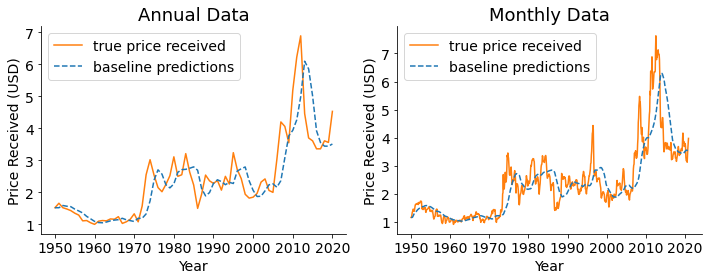

In [73]:
plt.subplots(2, figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(scrubbed_df_annual.index, scrubbed_df_annual['PRICE RECEIVED, MEASURED IN $ / BU'], label='true price received', color=u'#ff7f0e')
plt.plot(scrubbed_df_annual.index, scrubbed_df_annual['baseline'], label='baseline predictions', ls='--', color=u'#1f77b4')
plt.title('Annual Data', size=18)
plt.ylabel('Price Received (USD)', size=14)
plt.xlabel('Year', size=14)
plt.legend(fontsize=14)
plt.xticks(size=14)
plt.yticks(size=14)

plt.subplot(1,2,2)
plt.plot(scrubbed_df_monthly.index, scrubbed_df_monthly['PRICE RECEIVED, MEASURED IN $ / BU'], label='true price received', color=u'#ff7f0e')
plt.plot(scrubbed_df_monthly.index, scrubbed_df_monthly['baseline'], label='baseline predictions', ls='--', color=u'#1f77b4')
plt.title('Monthly Data', size=18)
plt.ylabel('Price Received (USD)', size=14)
plt.xlabel('Year', size=14)
plt.legend(fontsize=14)
plt.xticks(size=14)
plt.yticks(size=14)

sns.despine()
plt.tight_layout()
plt.show()

The baseline looks like a moving average of the data, slightly offset by time. Thus, the baseline is not going to catch extreme fluctuations in price and is going to work very poorly when the price drops rapidly.

I will do a quick check for missing data and then export the unified dataframes so they can be used for exploratory data analysis.

In [74]:
# Check both dataframes for missing values
print(scrubbed_df_annual.isna().sum(), '\n\n', scrubbed_df_monthly.isna().sum())

ACRES HARVESTED                         0
PRODUCTION, MEASURED IN BU              0
PRICE RECEIVED, MEASURED IN $ / BU      0
PRODUCTION, MEASURED IN $               0
YIELD, MEASURED IN BU / ACRE            0
Cooling Degree Days                     0
Heating Degree Days                     0
Precipitation                           0
Palmer Drought Severity Index (PDSI)    0
Average Temperature                     0
Maximum Temperature                     0
Minimum Temperature                     0
GDP                                     0
GDP_PCH                                 0
Inflation Rate YOY                      0
USPop                                   0
baseline                                0
dtype: int64 

 PRICE RECEIVED, MEASURED IN $ / BU      0
Cooling Degree Days                     0
Heating Degree Days                     0
Precipitation                           0
Palmer Drought Severity Index (PDSI)    0
Average Temperature                     0
Maximum Temperatur

Both dataframes appear to have no missing values. I will now export them.

In [75]:
# Export the data as csv files.
scrubbed_df_annual.to_csv('./DataFrames/scrubbed_df_annual.csv')
scrubbed_df_monthly.to_csv('./DataFrames/scrubbed_df_monthly.csv')

## Conclusions

The data cleaning / scrubbing process is now complete. The unified dataframes have been exported and are ready for EDA (exploratory data analysis).